# Imports

In [1]:
%load_ext autoreload
%autoreload 2
import glob
import os
import random
import pathlib

import pandas as pd
import torch
from Bio.PDB.Polypeptide import index_to_one
from collections import OrderedDict
from torch.utils.data import DataLoader, Dataset

from cavity_model import (
    CavityModel,
    ResidueEnvironment,
    ResidueEnvironmentsDataset,
)
import helpers
from typing import Optional, List
from visualization import scatter_pred_vs_true, plot_validation_performance
import pickle

import numpy as np
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", None)

%load_ext nb_black

<IPython.core.display.Javascript object>

# Cavity Model

Download and process Cavity Model data

In [2]:
# # Hack to find the conda activate path since bash scripts
# # don't necessarily work with the conda activate command
# conda_path = !which conda
# conda_path = list(conda_path)[0]
# conda_activate_path = pathlib.Path(conda_path).parent.parent / "bin" / "activate"
# if not conda_activate_path.is_file():
#     raise FileNotFoundError(
#         "Could not find your conda activate path needed for running bash scripts."
#     )

<IPython.core.display.Javascript object>

In [3]:
# # Run shell script that takes a .txt file with PDBIDs as input.
# !./get_and_parse_pdbs_for_cavity_model.sh $conda_activate_path data/pdbids_2336.txt

<IPython.core.display.Javascript object>

Global variables

In [4]:
# Main parameters
# WARM_START: Optional[str] = "cavity_models/model_epoch_02.pt"
WARM_START: Optional[List[str]] = [
    "cavity_models/repeat_00_model_epoch_01.pt",
    "cavity_models/repeat_01_model_epoch_02.pt",
    "cavity_models/repeat_02_model_epoch_01.pt",
    "cavity_models/repeat_03_model_epoch_02.pt",
    "cavity_models/repeat_04_model_epoch_02.pt",
    "cavity_models/repeat_05_model_epoch_02.pt",
]
DEVICE: str = "cuda"  # "cpu" or "cuda"
TRAIN_VAL_SPLIT: float = 0.9
BATCH_SIZE: int = 100
SHUFFLE_PDBS: bool = True
LEARNING_RATE: float = 2e-4
EPOCHS: int = 6
PATIENCE_CUTOFF: int = 0
EPS: float = 1e-9
N_MODEL_REPEATS = 6

# Parameters for simulation stride
STRIDE_FRAGMENTS: int = 2  # 2
STRIDE_MD: int = 4  # 4

# Parameters specific to downstream model
BATCH_SIZE_DDG: int = 40
SHUFFLE_DDG: bool = True
LEARNING_RATE_DDG: float = 1e-3
EPOCHS_DDG: int = 200

# Mapping between data keys and titles/colors for plots
dataset_name_mapping = {
    "dms": "DMS",
    "guerois": "Guerois",
    "protein_g": "Protein G",
    "symmetric_direct": "Symmetric (Direct)",
    "symmetric_inverse": "Symmetric (Inverse)",
}

dataset_color_mapping = {
    "dms": "steelblue",
    "guerois": "firebrick",
    "protein_g": "forestgreen",
    "symmetric_direct": "olive",
    "symmetric_inverse": "olive",
}

<IPython.core.display.Javascript object>

Load Parsed PDBs and perform train/val split

Train the cavity model

In [5]:
if WARM_START is None:
    # Create directory for model files
    models_dirpath = "cavity_models/"
    if not os.path.exists(models_dirpath):
        os.mkdir(models_dirpath)

    best_model_paths = []
    for i in range(N_MODEL_REPEATS):
        print(f"Repeat: {i:02d}")

        # Parse data
        parsed_pdb_filenames = sorted(glob.glob("data/pdbs/parsed/*coord*"))
        if SHUFFLE_PDBS:
            random.shuffle(parsed_pdb_filenames)
        (
            dataloader_train,
            dataset_train,
            dataloader_val,
            dataset_val,
        ) = helpers.train_val_split(
            parsed_pdb_filenames, TRAIN_VAL_SPLIT, DEVICE, BATCH_SIZE
        )

        # Define model
        cavity_model_net = CavityModel(DEVICE).to(DEVICE)
        loss_function = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(cavity_model_net.parameters(), lr=LEARNING_RATE)

        model_prefix = f"repeat_{i:02d}"
        # Train loop
        best_model_path = helpers.train_loop(
            dataloader_train,
            dataloader_val,
            cavity_model_net,
            loss_function,
            optimizer,
            model_prefix,
            EPOCHS,
            PATIENCE_CUTOFF,
        )

        best_model_paths.append(best_model_path)
else:
    print(f"Warm start: {WARM_START}")

Warm start: ['cavity_models/repeat_00_model_epoch_01.pt', 'cavity_models/repeat_01_model_epoch_02.pt', 'cavity_models/repeat_02_model_epoch_01.pt', 'cavity_models/repeat_03_model_epoch_02.pt', 'cavity_models/repeat_04_model_epoch_02.pt', 'cavity_models/repeat_05_model_epoch_02.pt']


<IPython.core.display.Javascript object>

# ddG Prediction

Parse PDBs for DMS, Guerois and Protein G data sets

In [6]:
# # Parse PDBs for which we have ddG data
# !./get_and_parse_pdbs_for_dowstream_task.sh $conda_activate_path

<IPython.core.display.Javascript object>

Make dict for residue environments for easy look up

In [7]:
# Create temporary residue environment datasets as dicts to more easily match ddG data
parsed_pdbs_wildcards = {
    "dms": "data/data_dms/pdbs_parsed/*coord*",
    "protein_g": "data/data_protein_g/pdbs_parsed/*coord*",
    "guerois": "data/data_guerois/pdbs_parsed/*coord*",
    "symmetric": "data/data_symmetric/pdbs_parsed/*coord*",
}

resenv_datasets_look_up = {}
for dataset_key, pdbs_wildcard in parsed_pdbs_wildcards.items():
    parsed_pdb_filenames = sorted(glob.glob(pdbs_wildcard))
    dataset = ResidueEnvironmentsDataset(parsed_pdb_filenames, transformer=None)
    dataset_look_up = {}
    for resenv in dataset:
        key = (
            f"{resenv.pdb_id}{resenv.chain_id}_{resenv.pdb_residue_number}"
            f"{index_to_one(resenv.restype_index)}"
        )
        dataset_look_up[key] = resenv
    resenv_datasets_look_up[dataset_key] = dataset_look_up

<IPython.core.display.Javascript object>

Load ddG data to dataframe

In [8]:
ddg_data_dict = OrderedDict()
ddg_data_dict = {
    "dms": pd.read_csv("data/data_dms/ddgs_parsed.csv"),
    "protein_g": pd.read_csv("data/data_protein_g/ddgs_parsed.csv"),
    "guerois": pd.read_csv("data/data_guerois/ddgs_parsed.csv"),
    "symmetric_direct": pd.read_csv("data/data_symmetric/ddgs_parsed_direct.csv"),
    "symmetric_inverse": pd.read_csv("data/data_symmetric/ddgs_parsed_inverse.csv"),
}

<IPython.core.display.Javascript object>

Populate dataframes with wt ResidueEnvironment objects and wt and mt restype indices

In [9]:
helpers.populate_dfs_with_resenvs(ddg_data_dict, resenv_datasets_look_up)

Dropping data points where residue is not defined in structure or due to missing parsed pdb file
dropped 1187 / 8096 data points from dataset dms
dropped    0 /  907 data points from dataset protein_g
dropped    0 /  911 data points from dataset guerois
dropped    0 /  342 data points from dataset symmetric_direct
dropped    0 /  342 data points from dataset symmetric_inverse


<IPython.core.display.Javascript object>

Populate dataframes with predicted NLLs and isolated WT and MT predicted NLLs as well as NLFs

In [10]:
# Load best performing cavity model from previos training
if WARM_START:
    best_model_paths = WARM_START

cavity_model_infer_nets = []
for best_path in best_model_paths:
    cavity_model_infer_net = CavityModel(DEVICE).to(DEVICE)
    cavity_model_infer_net.load_state_dict(torch.load(best_path))
    _ = cavity_model_infer_net.eval()
    cavity_model_infer_nets.append(cavity_model_infer_net)

<IPython.core.display.Javascript object>

In [11]:
if not os.path.exists("processed_data_frames.pickle"):
    helpers.populate_dfs_with_nlls_and_nlfs(
        ddg_data_dict, cavity_model_infer_nets, DEVICE, BATCH_SIZE, EPS
    )

<IPython.core.display.Javascript object>

## Process results without downstream model

### Symmetric, use both structures

In [12]:
if not os.path.exists("processed_data_frames.pickle"):
    helpers.get_predictions_both_structures(ddg_data_dict, len(cavity_model_infer_nets))

<IPython.core.display.Javascript object>

### Phaistos statistics

In [13]:
# # Output 11 amino acid sequence fragment for MC simulations (Only done once)
# helpers.output_sequence_fragments_to_csv(ddg_data_dict)

<IPython.core.display.Javascript object>

In [14]:
# for data_set in ["protein_g", "dms", "guerois"]:
#     ddg_data_dict[data_set] = ddg_data_dict[data_set].iloc[0:20]

<IPython.core.display.Javascript object>

In [15]:
if not os.path.exists("processed_data_frames.pickle"):
    for data_set in ["protein_g", "dms", "guerois"]:
        helpers.infer_probabilities_for_center_residues(
            ddg_data_dict,
            data_set,
            cavity_model_infer_nets,
            DEVICE,
            EPS,
            is_wt=True,
            stride=STRIDE_FRAGMENTS,
        )
        helpers.infer_probabilities_for_center_residues(
            ddg_data_dict,
            data_set,
            cavity_model_infer_nets,
            DEVICE,
            EPS,
            is_wt=False,
            stride=STRIDE_FRAGMENTS,
        )

        helpers.add_ddg_preds_with_unfolded_state(
            ddg_data_dict, data_set, len(cavity_model_infer_nets)
        )

<IPython.core.display.Javascript object>

##### Molecular dynamics

In [16]:
if not os.path.exists("processed_data_frames.pickle"):
    # Infer NLLs for WT and MT  in columns wt_nll_md and mt_nll_md
    helpers.infer_molecular_dynamics_nlls(
        ddg_data_dict,
        "protein_g",
        DEVICE,
        EPS,
        cavity_model_infer_nets,
        stride=STRIDE_MD,
        is_npt_ensemble=True,
        use_residue_number_map=True,
    )

    helpers.infer_molecular_dynamics_nlls(
        ddg_data_dict,
        "guerois",
        DEVICE,
        EPS,
        cavity_model_infer_nets,
        stride=STRIDE_MD,
        is_npt_ensemble=False,  # Maybe fix the bug with NPT ensemble
        use_residue_number_map=True,
    )

    helpers.infer_molecular_dynamics_nlls(
        ddg_data_dict,
        "dms",
        DEVICE,
        EPS,
        cavity_model_infer_nets,
        stride=STRIDE_MD,
        is_npt_ensemble=True,
        use_residue_number_map=False,
    )

<IPython.core.display.Javascript object>

In [17]:
if not os.path.exists("processed_data_frames.pickle"):
    # Calculate DDgs
    helpers.add_ddg_preds_with_md_simulations(
        ddg_data_dict, "protein_g", len(cavity_model_infer_nets)
    )
    helpers.add_ddg_preds_with_md_simulations(
        ddg_data_dict, "guerois", len(cavity_model_infer_nets)
    )
    helpers.add_ddg_preds_with_md_simulations(
        ddg_data_dict, "dms", len(cavity_model_infer_nets)
    )

<IPython.core.display.Javascript object>

# Cache

In [18]:
if not os.path.exists("processed_data_frames.pickle"):
    with open("processed_data_frames.pickle", "wb") as handle:
        pickle.dump(ddg_data_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

<IPython.core.display.Javascript object>

# Load

In [19]:
with open("processed_data_frames.pickle", "rb") as handle:
    ddg_data_dict = pickle.load(handle)

<IPython.core.display.Javascript object>

# Figures

### Ultra Vanilla predictions

/home/chz526/final_project/Cavity_Model_Demo/visualization.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


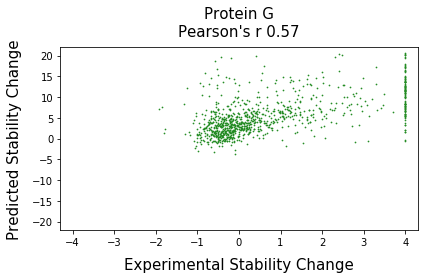

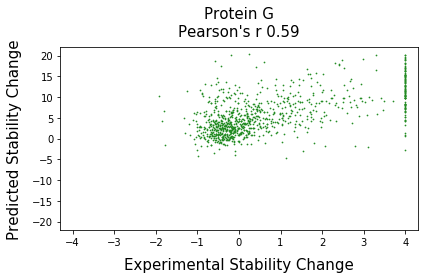

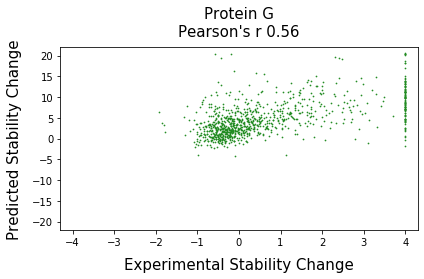

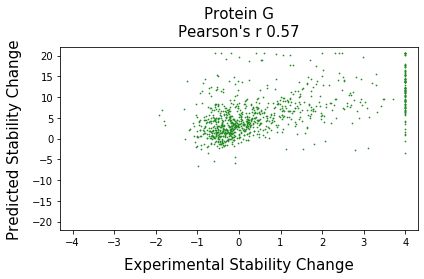

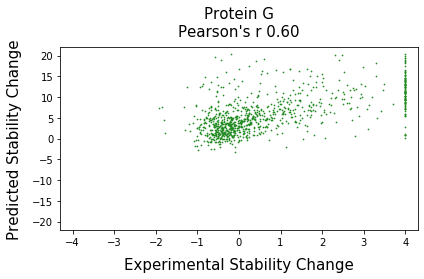

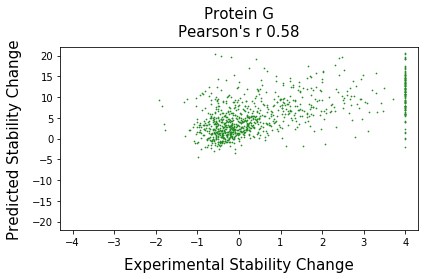

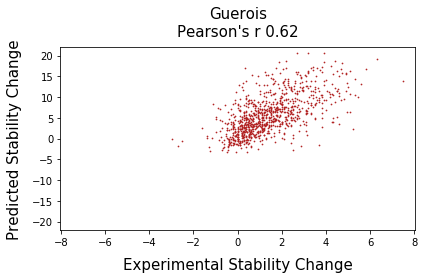

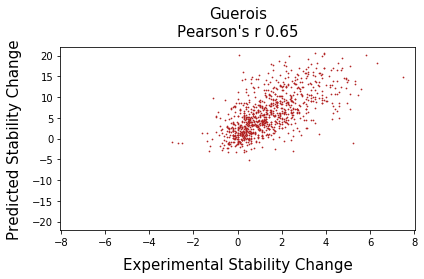

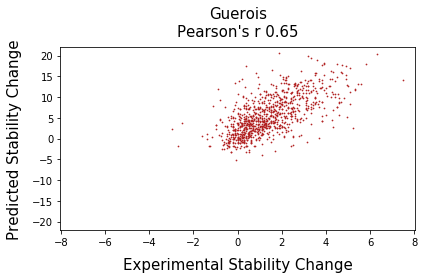

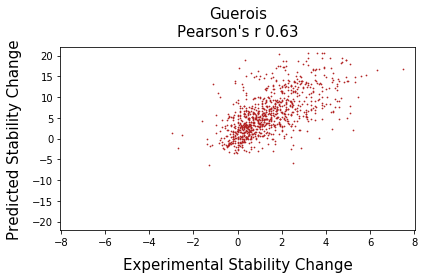

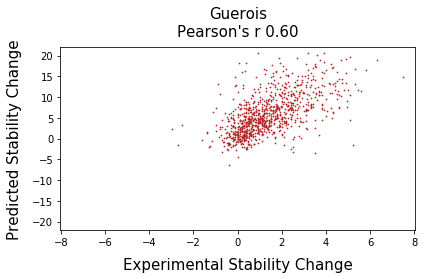

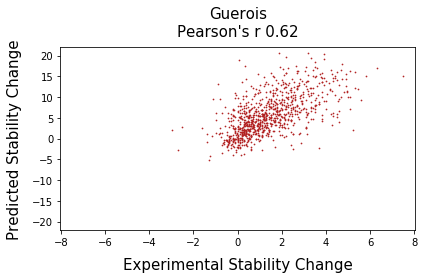

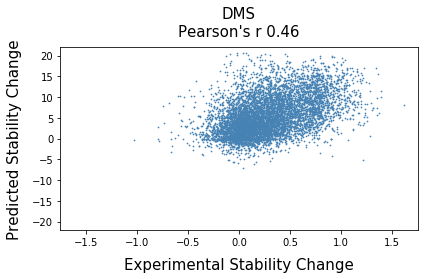

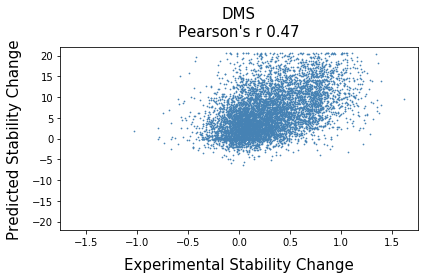

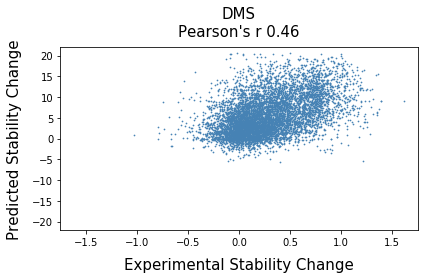

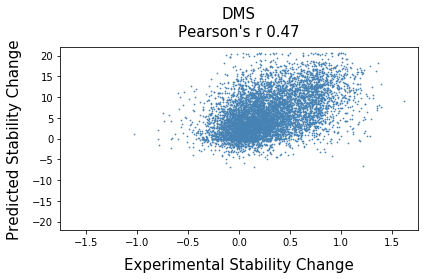

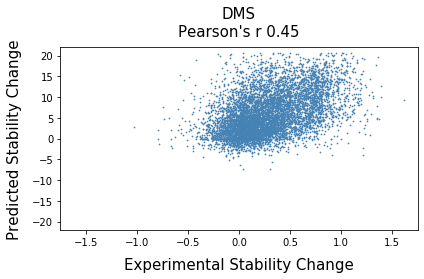

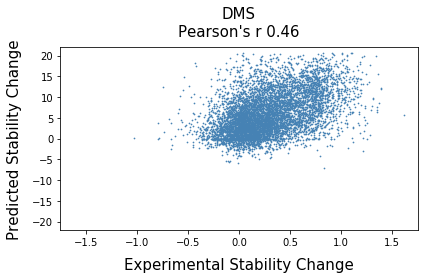

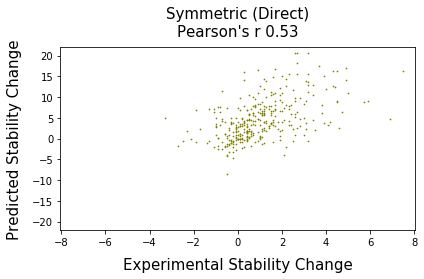

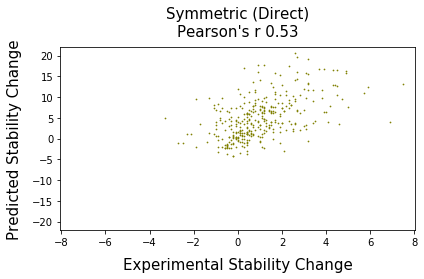

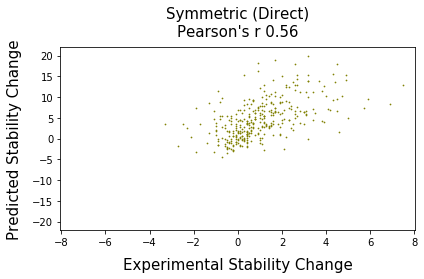

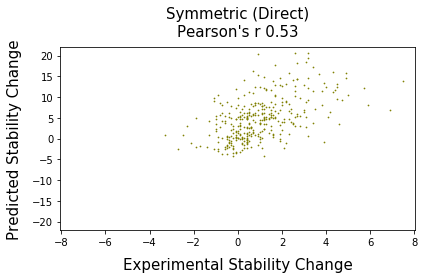

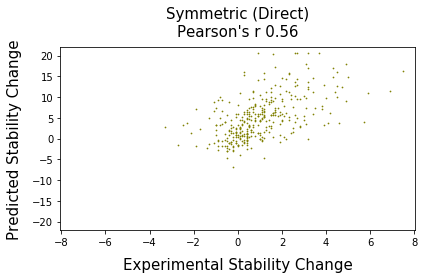

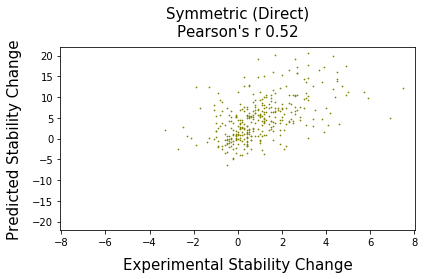

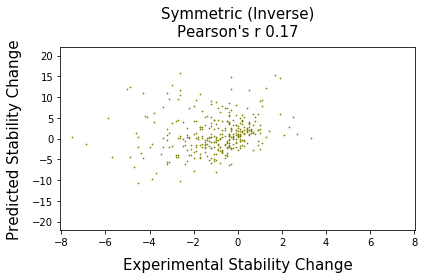

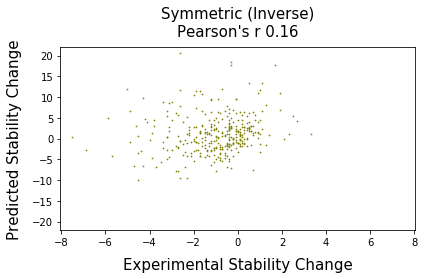

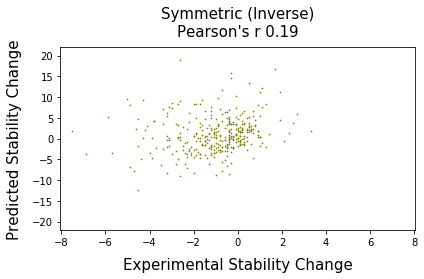

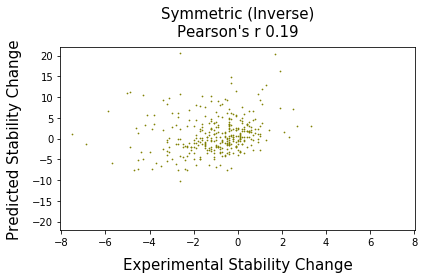

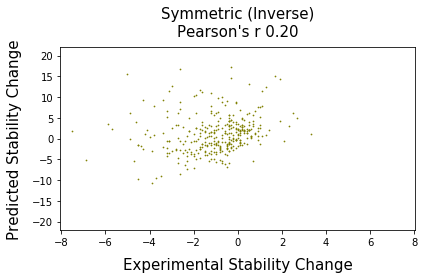

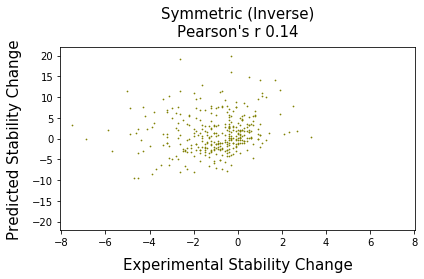

<IPython.core.display.Javascript object>

In [20]:
from collections import defaultdict

ULTRA_VANILLA_RS = defaultdict(list)
for data_key in [
    "protein_g",
    "guerois",
    "dms",
    "symmetric_direct",
    "symmetric_inverse",
]:
    ddg_col = "ddg"

    # Dump data for wouter
    ddg_pred_col = f"ddg_pred_ultra_vanilla_0"
    if data_key == "symmetric_direct":

        df_figure_5_single_structure = pd.DataFrame(
            {
                "ddg_dir_exp": ddg_data_dict[data_key]["ddg"],
                "ddg_dir_pred": ddg_data_dict[data_key][ddg_pred_col],
            }
        )
    elif data_key == "symmetric_inverse":
        df_figure_5_single_structure["ddg_inv_exp"] = ddg_data_dict[data_key]["ddg"]
        df_figure_5_single_structure["ddg_inv_pred"] = ddg_data_dict[data_key][
            ddg_pred_col
        ]
        df_figure_5_single_structure.to_csv(
            "wouter_plot_data/fig_5_single_structure.csv", index_label="i"
        )

    for i in range(len(cavity_model_infer_nets)):
        ddg_pred_col = f"ddg_pred_ultra_vanilla_{i}"

        fig, ax, pearsons_r = scatter_pred_vs_true(
            ddg_data_dict[data_key][ddg_col],
            ddg_data_dict[data_key][ddg_pred_col],
            color=dataset_color_mapping[data_key],
            title=dataset_name_mapping[data_key],
        )

        ULTRA_VANILLA_RS[data_key].append(pearsons_r)

### Vanilla PDB statistics

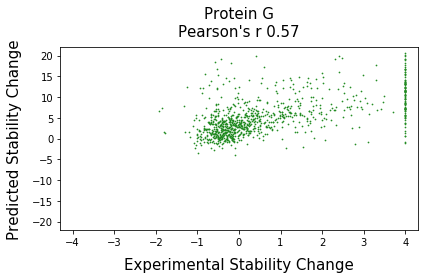

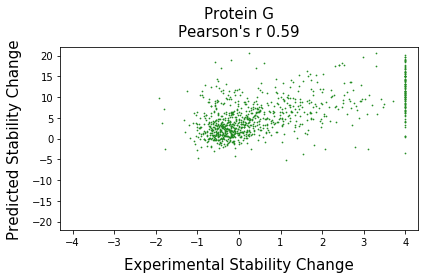

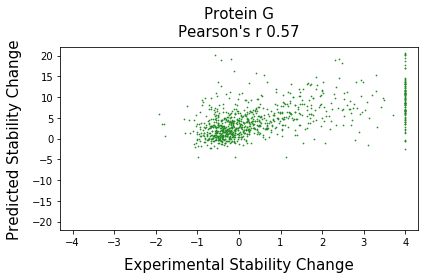

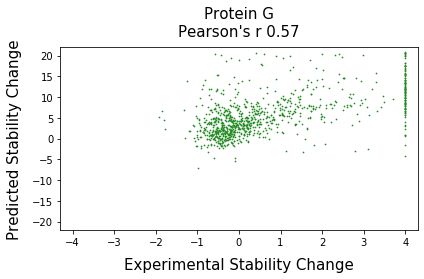

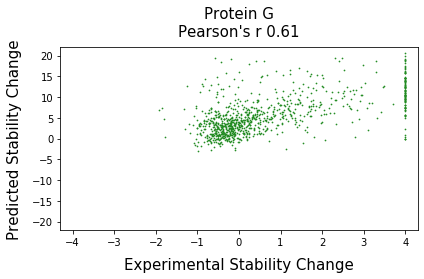

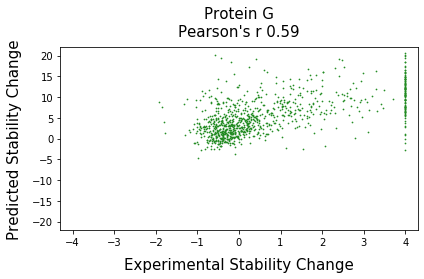

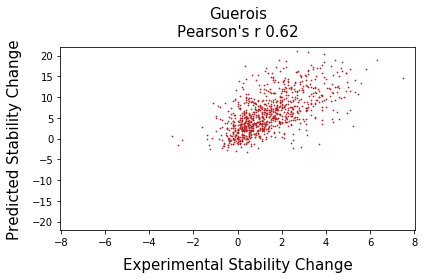

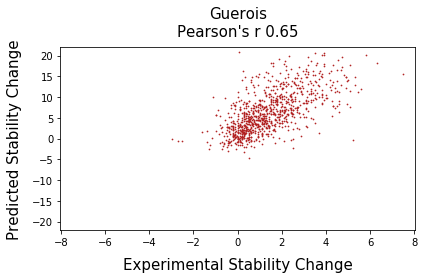

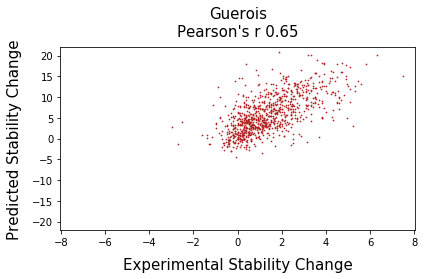

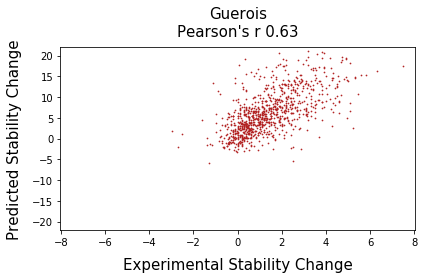

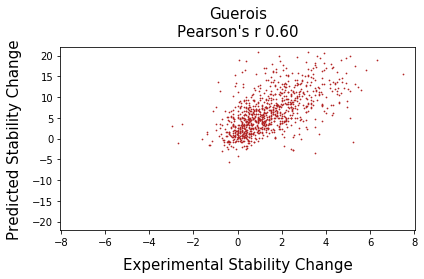

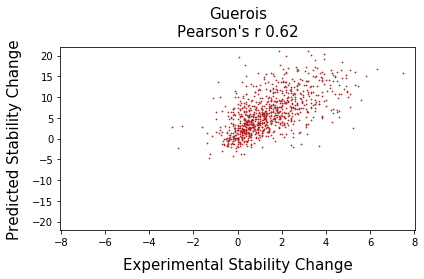

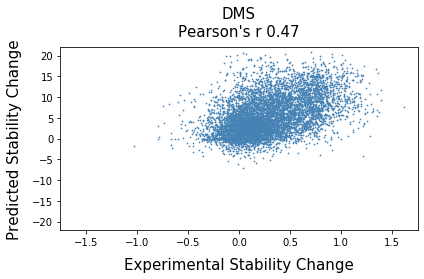

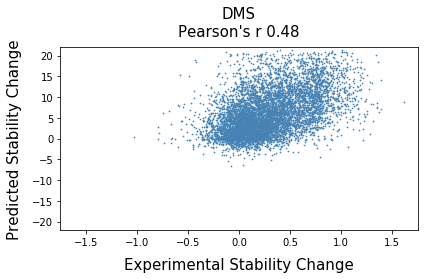

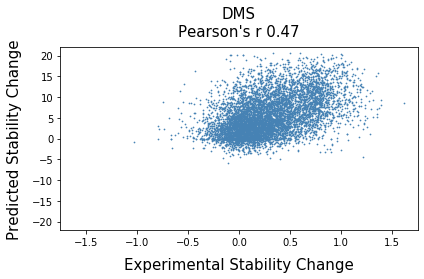

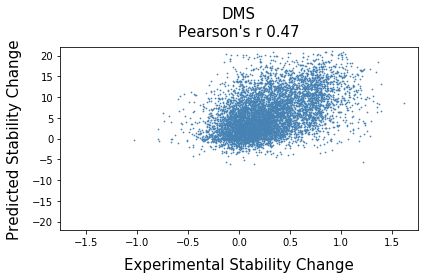

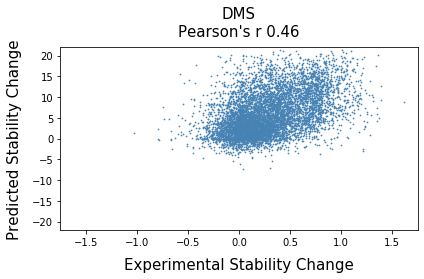

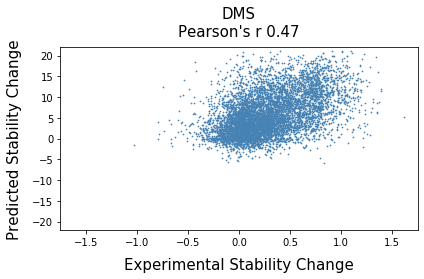

<IPython.core.display.Javascript object>

In [21]:
VANILLA_PDB_STATISTICS_RS = defaultdict(list)
for data_key in [
    "protein_g",
    "guerois",
    "dms",
]:
    ddg_col = "ddg"

    for i in range(len(cavity_model_infer_nets)):
        ddg_pred_col = f"ddg_pred_no_ds_{i}"

        fig, ax, pearsons_r = scatter_pred_vs_true(
            ddg_data_dict[data_key][ddg_col],
            ddg_data_dict[data_key][ddg_pred_col],
            color=dataset_color_mapping[data_key],
            title=dataset_name_mapping[data_key],
        )

        VANILLA_PDB_STATISTICS_RS[data_key].append(pearsons_r)

### Vanilla IDP statistics

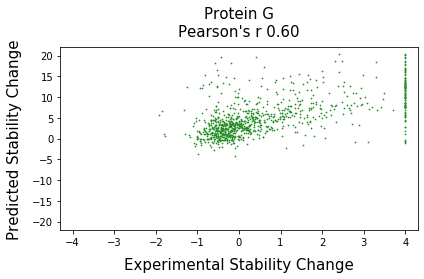

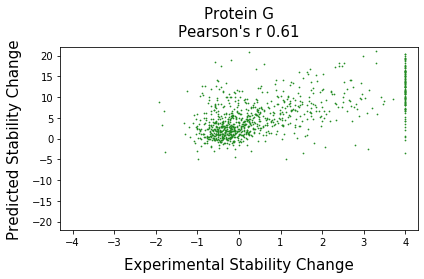

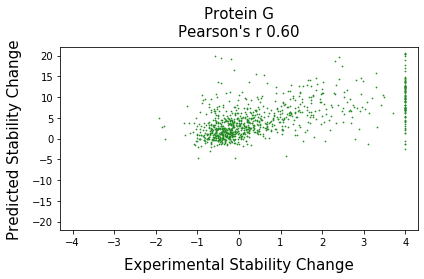

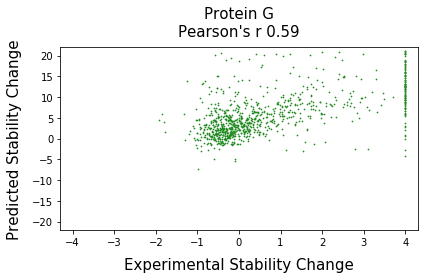

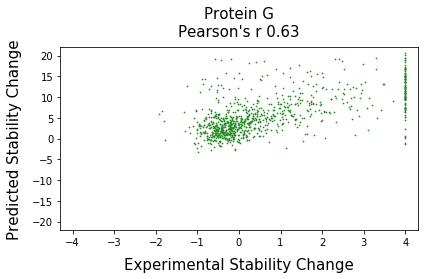

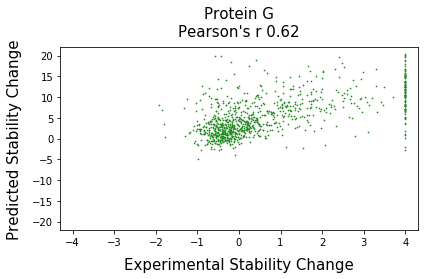

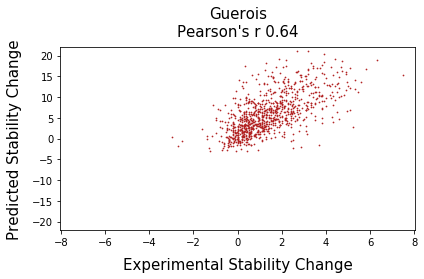

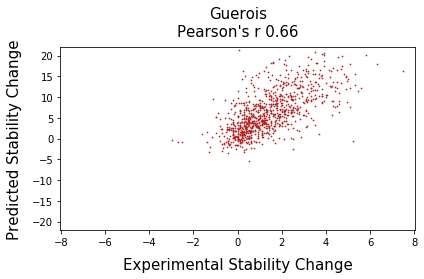

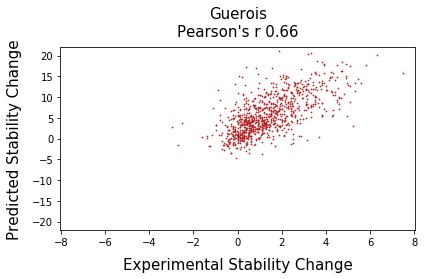

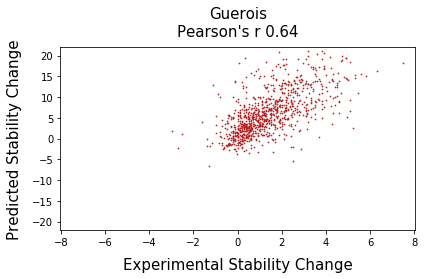

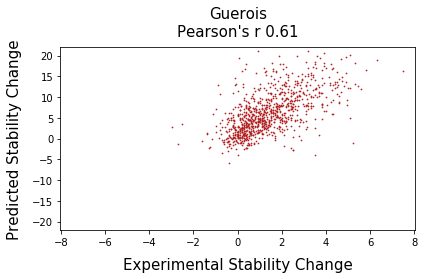

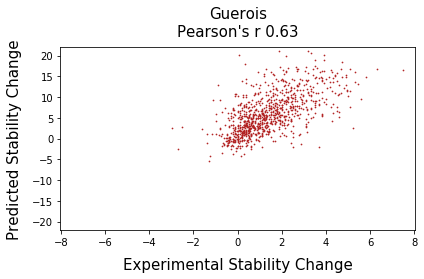

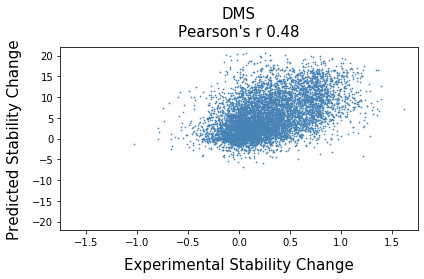

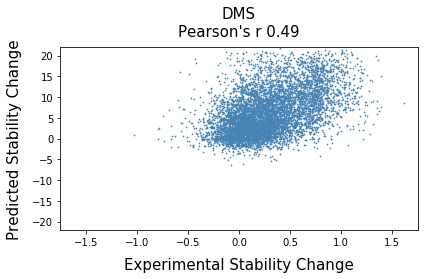

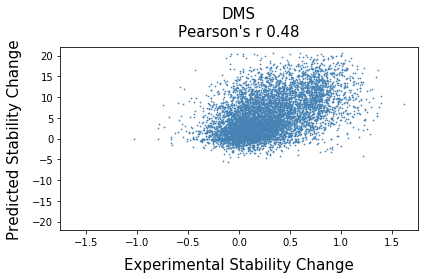

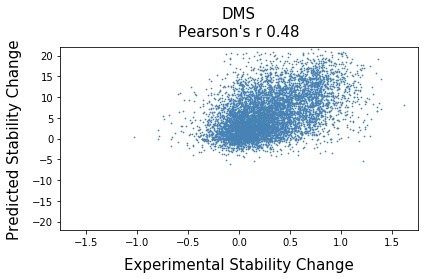

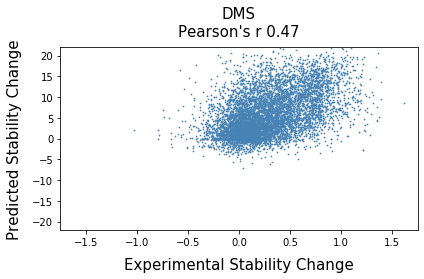

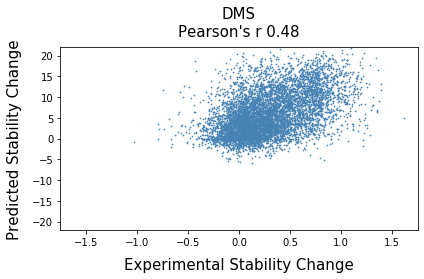

<IPython.core.display.Javascript object>

In [22]:
VANILLA_IDP_STATISTICS_RS = defaultdict(list)
for data_key in [
    "protein_g",
    "guerois",
    "dms",
]:
    ddg_col = "ddg"

    for i in range(len(cavity_model_infer_nets)):
        ddg_pred_col = f"ddg_pred_idp_no_ds_{i}"

        fig, ax, pearsons_r = scatter_pred_vs_true(
            ddg_data_dict[data_key][ddg_col],
            ddg_data_dict[data_key][ddg_pred_col],
            color=dataset_color_mapping[data_key],
            title=dataset_name_mapping[data_key],
        )
        VANILLA_IDP_STATISTICS_RS[data_key].append(pearsons_r)

### Both structure symmetric

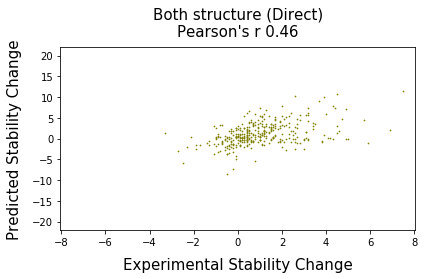

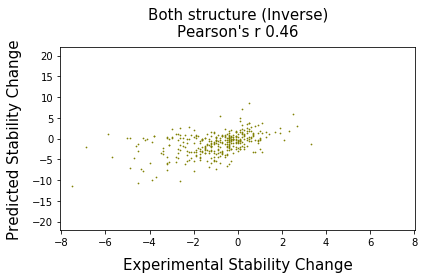

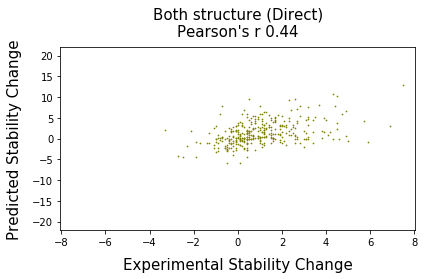

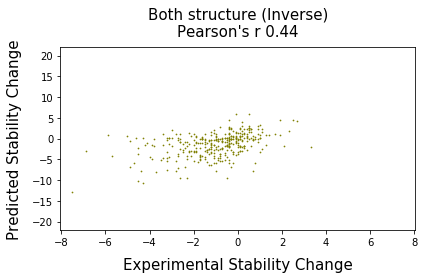

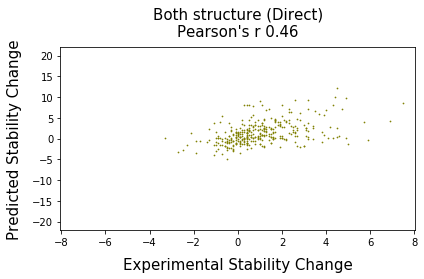

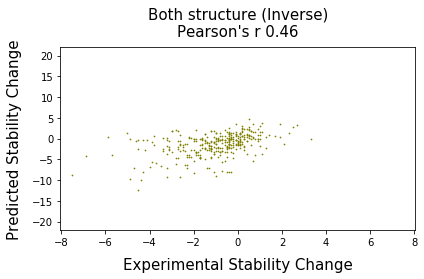

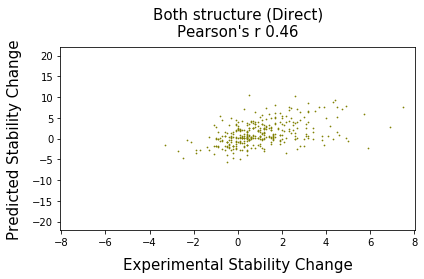

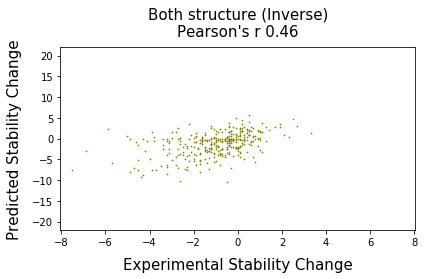

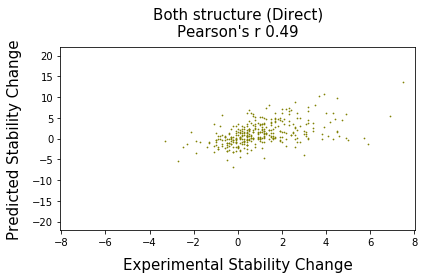

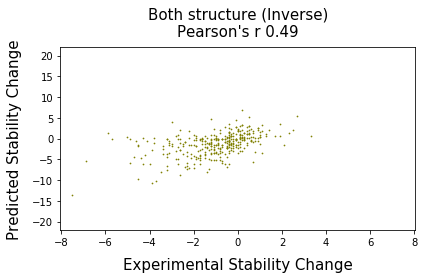

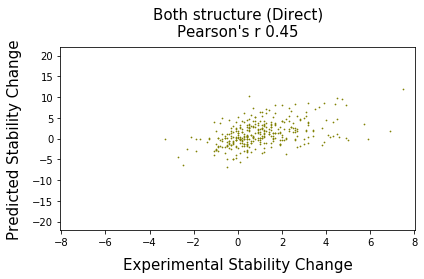

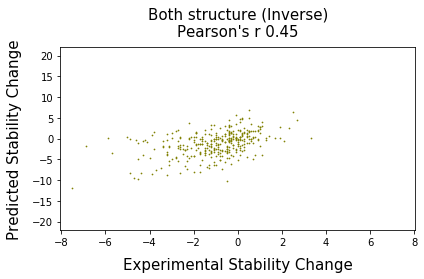

<IPython.core.display.Javascript object>

In [23]:
VANILLA_BOTH_STRUCTURES_RS = defaultdict(list)

for i in range(len(cavity_model_infer_nets)):
    # Dump plots for wouter
    if i == 0:
        df_figure_5_both_structures = pd.DataFrame({
            "ddg_dir_exp": ddg_data_dict["symmetric_both"]["ddg_dir"],
            "ddg_inv_exp": ddg_data_dict["symmetric_both"]["ddg_inv"],
            "ddg_pred_dir_both_structures": ddg_data_dict["symmetric_both"][f"ddg_pred_no_ds_both_dir_{i}"],
            "ddg_pred_inv_both_structures": ddg_data_dict["symmetric_both"][f"ddg_pred_no_ds_both_inv_{i}"]
}) 
        df_figure_5_both_structures.to_csv("wouter_plot_data/fig5_both_structures.csv", index_label="i")
        
    
    # Plot prediction for ddg direct using both structures
    fig, ax, pearsons_r = scatter_pred_vs_true(
        ddg_data_dict["symmetric_both"]["ddg_dir"],
        ddg_data_dict["symmetric_both"][f"ddg_pred_no_ds_both_dir_{i}"],
        color="olive",
        title="Both structure (Direct)",
    )
    VANILLA_BOTH_STRUCTURES_RS[f"symmetric_direct"].append(pearsons_r)

    # Plot prediction for ddg inverse using both structures
    fig, ax, pearsons_r = scatter_pred_vs_true(
        ddg_data_dict["symmetric_both"][f"ddg_inv"],
        ddg_data_dict["symmetric_both"][f"ddg_pred_no_ds_both_inv_{i}"],
        color="olive",
        title="Both structure (Inverse)",
    )
    VANILLA_BOTH_STRUCTURES_RS["symmetric_inverse"].append(pearsons_r)


In [24]:
ddg_data_dict["protein_g"]

pdbid chainid variant     ddg  \
0    1PGA       A     M1A -0.1407   
1    1PGA       A     M1D -0.3795   
2    1PGA       A     M1E -0.6414   
3    1PGA       A     M1L -0.4573   
4    1PGA       A     T2E -0.1299   
..    ...     ...     ...     ...   
902  1PGA       A     M1Q -0.4025   
903  1PGA       A     M1R -0.5102   
904  1PGA       A     M1S -0.6800   
905  1PGA       A     M1T -0.4983   
906  1PGA       A     M1Y -0.6800   

                                                resenv  wt_idx  mt_idx  \
0    <ResidueEnvironment with 130 atoms. pdb_id: 1P...      10       0   
1    <ResidueEnvironment with 130 atoms. pdb_id: 1P...      10       2   
2    <ResidueEnvironment with 130 atoms. pdb_id: 1P...      10       3   
3    <ResidueEnvironment with 130 atoms. pdb_id: 1P...      10       9   
4    <ResidueEnvironment with 157 atoms. pdb_id: 1P...      16       3   
..                                                 ...     ...     ...   
902  <ResidueEnvironment with 130 atoms. pdb_id: 1P...      10      13   
903  <ResidueEnvironment with 130 atoms. pdb_id: 1P...      10      14   
904  <ResidueEnvironment with 130 atoms. pdb_id: 1P...      10      15   
905  <ResidueEnvironment with 130 atoms. pdb_id: 1P...      10      16   
906  <ResidueEnvironment with 130 atoms. pdb_id: 1P...      10      19   

                                                nlls_0  wt_nll_0  mt_nll_0  \
0    [3.3562713, 3.9009457, 4.588267, 2.5037181, 6....  1.401340  3.356271   
1    [3.3562713, 3.9009457, 4.588267, 2.5037181, 6....  1.401340  4.588267   
2    [3.3562713, 3.9009457, 4.588267, 2.5037181, 6....  1.401340  2.503718   
3    [3.3562713, 3.9009457, 4.588267, 2.5037181, 6....  1.401340  4.369485   
4    [6.8084702, 8.124421, 5.84448, 2.760767, 6.774...  0.773342  2.760767   
..                                                 ...       ...       ...   
902  [3.401909, 3.9082263, 4.657872, 2.5947013, 6.4...  1.358469  2.846078   
903  [3.401909, 3.9082263, 4.657872, 2.5947013, 6.4...  1.358469  4.379262   
904  [3.401909, 3.9082263, 4.657872, 2.5947013, 6.4...  1.358469  4.249102   
905  [3.401909, 3.9082263, 4.657872, 2.5947013, 6.4...  1.358469  0.872728   
906  [3.401909, 3.9082263, 4.657872, 2.5947013, 6.4...  1.358469  6.107160   

     wt_nlf_0  mt_nlf_0  ddg_pred_ultra_vanilla_0  ddg_pred_no_ds_0  \
0    3.785957  2.483982                  1.954931          3.256906   
1    3.785957  2.824680                  3.186927          4.148204   
2    3.785957  2.712832                  1.102378          2.175503   
3    3.785957  2.433114                  2.968145          4.320988   
4    2.896883  2.712832                  1.987425          2.171476   
..        ...       ...                       ...               ...   
902  3.785957  3.338515                  1.487608          1.935050   
903  3.785957  3.035567                  3.020793          3.771183   
904  3.785957  2.844502                  2.890632          3.832087   
905  3.785957  2.896883                 -0.485741          0.403333   
906  3.785957  3.311580                  4.748691          5.223068   

     wt_idp_nlf_0  mt_idp_nlf_0  ddg_pred_idp_no_ds_0  \
0        3.974215      2.679916              3.249230   
1        3.974215      2.836449              4.324693   
2        3.974215      2.405165              2.671428   
3        3.974215      2.544290              4.398070   
4        2.861809      2.405165              2.444070   
..            ...           ...                   ...   
902      3.974215      3.039859              2.421964   
903      3.974215      2.705216              4.289792   
904      3.974215      2.533442              4.331405   
905      3.974215      2.861809              0.626664   
906      3.974215      4.207830              4.515076   

                                                nlls_1  wt_nll_1  mt_nll_1  \
0    [3.269724, 5.208636, 2.8909955, 2.3118136, 4.3...  1.006030  3.269724   
1    [3.269724, 5.208636, 2.8909955, 2.

<IPython.core.display.Javascript object>

### Phaistos statistics

/home/chz526/final_project/Cavity_Model_Demo/visualization.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


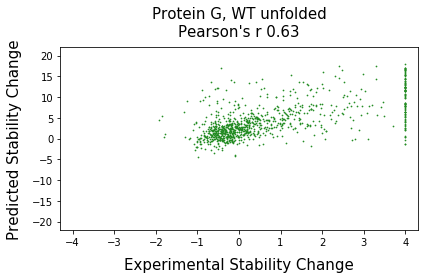

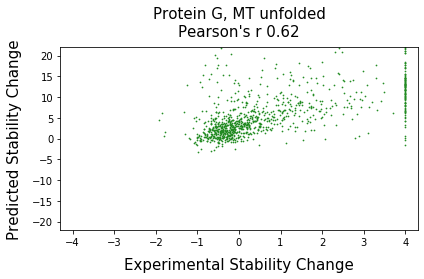

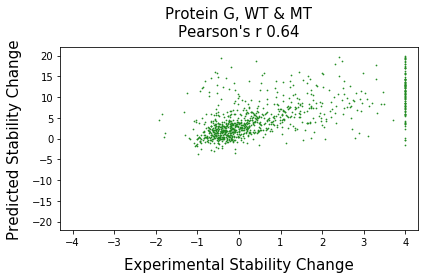

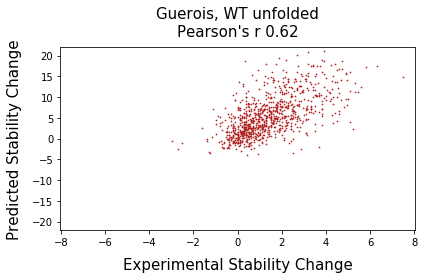

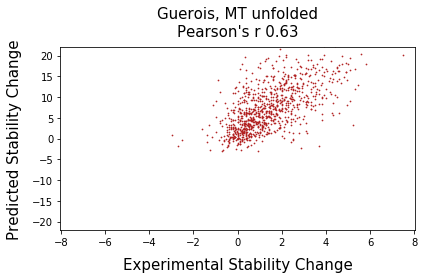

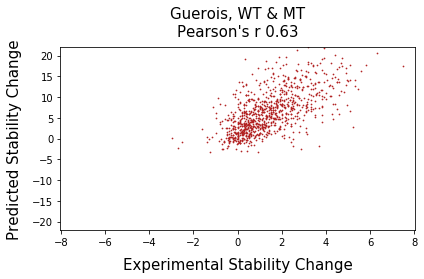

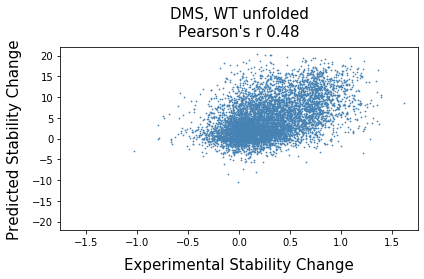

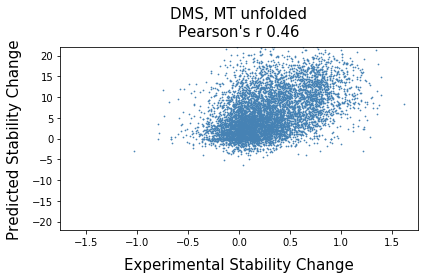

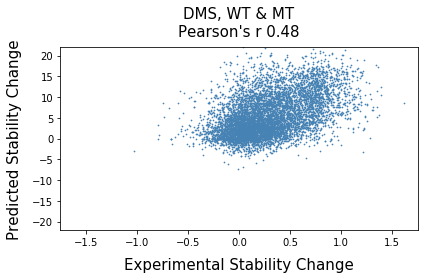

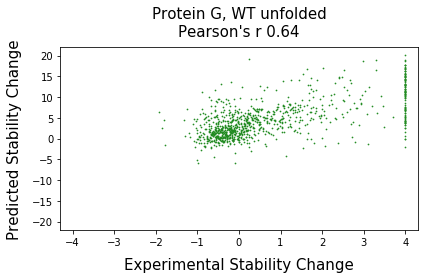

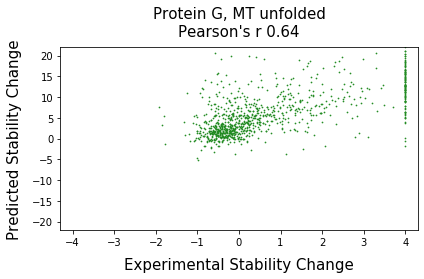

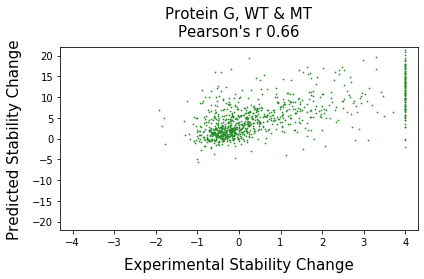

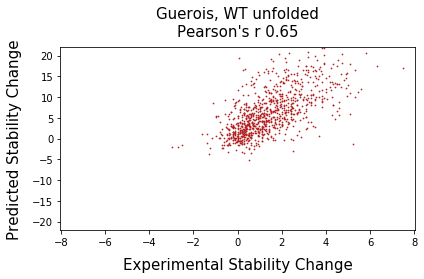

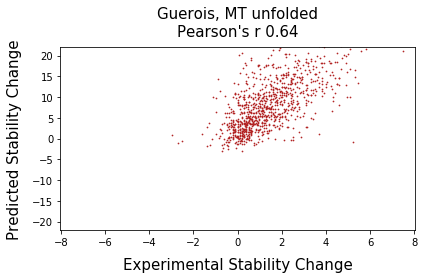

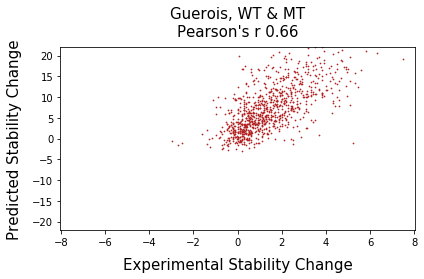

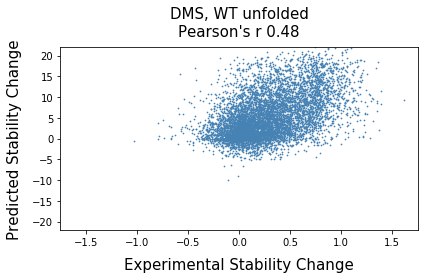

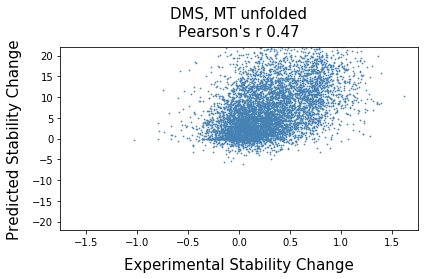

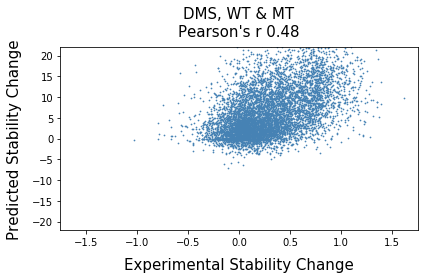

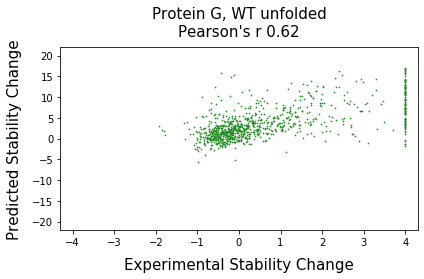

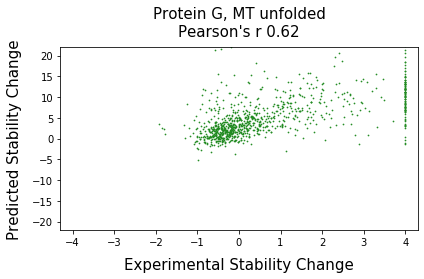

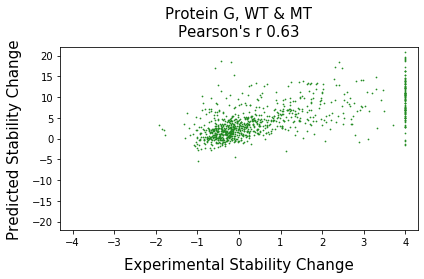

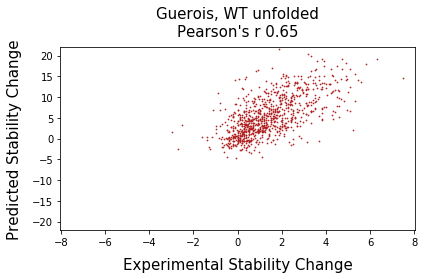

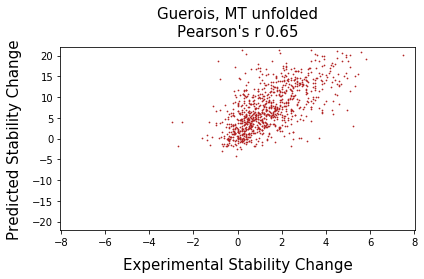

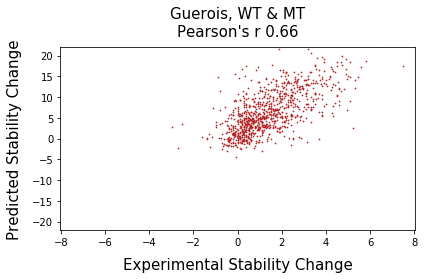

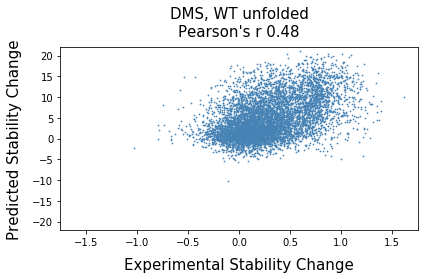

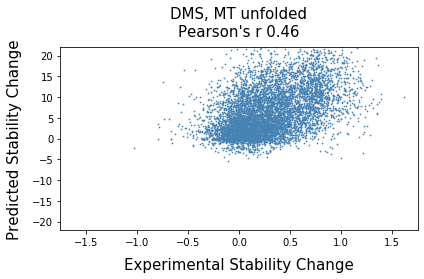

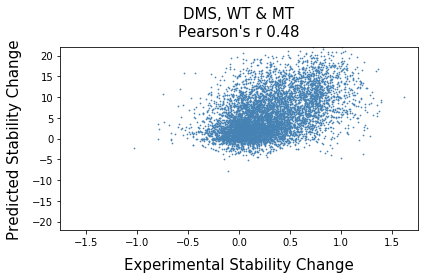

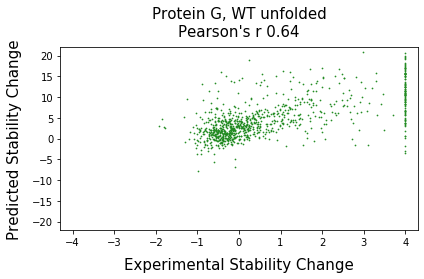

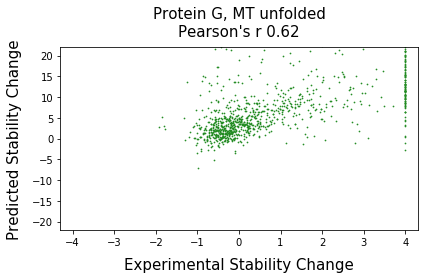

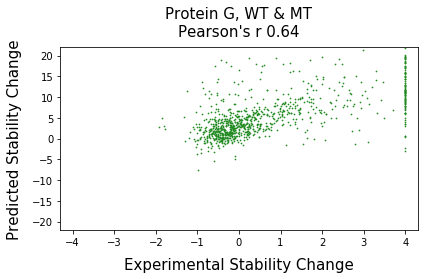

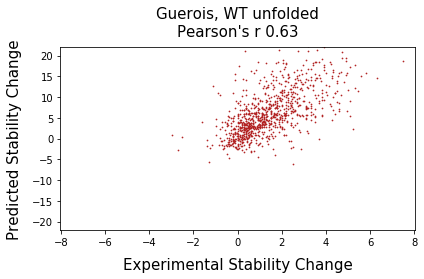

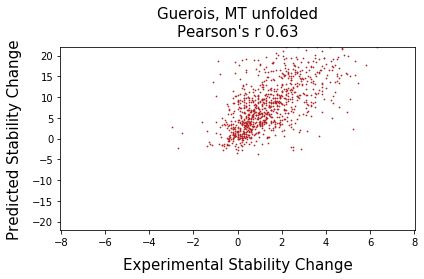

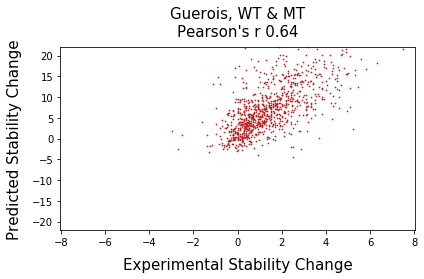

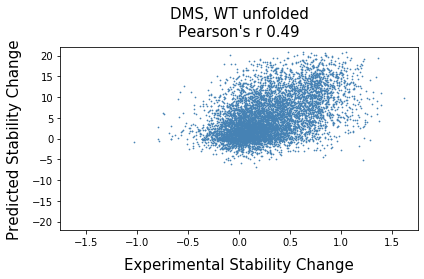

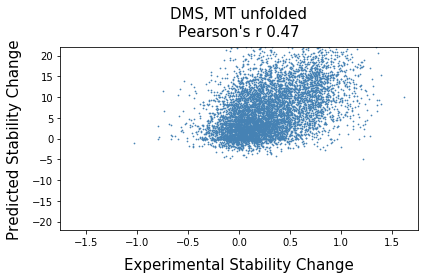

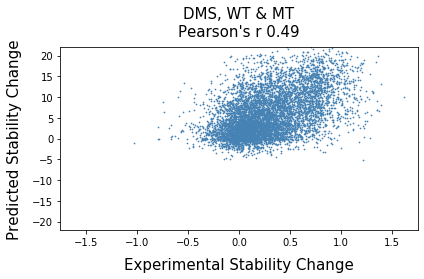

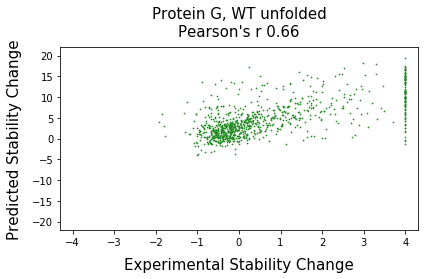

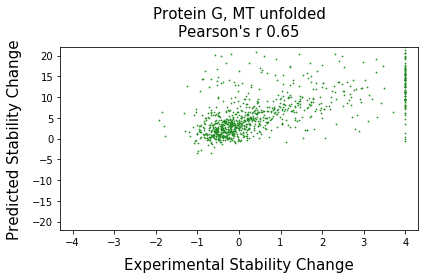

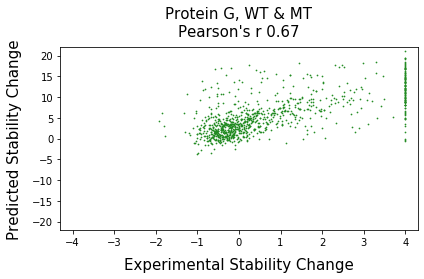

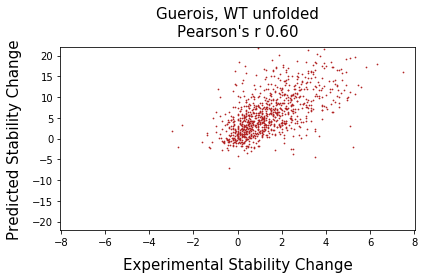

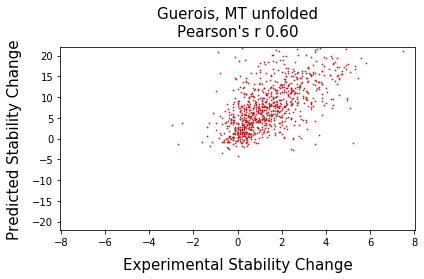

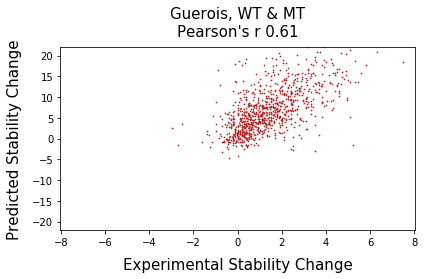

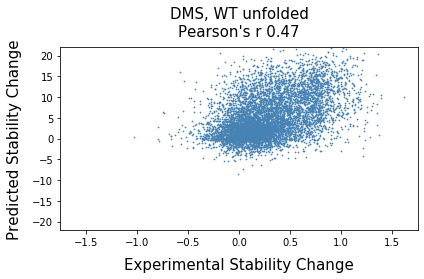

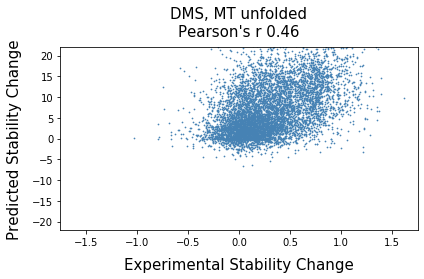

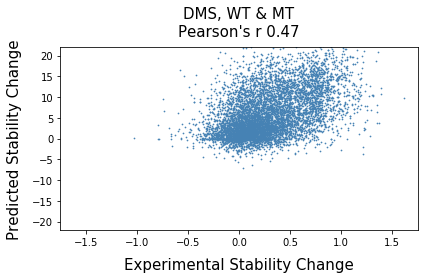

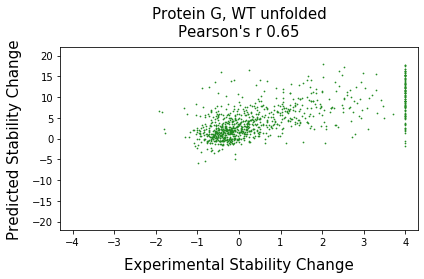

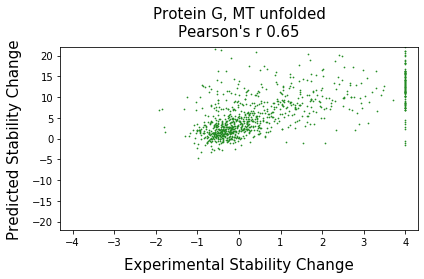

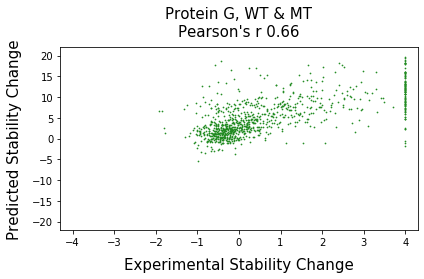

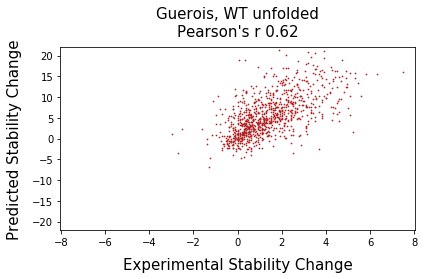

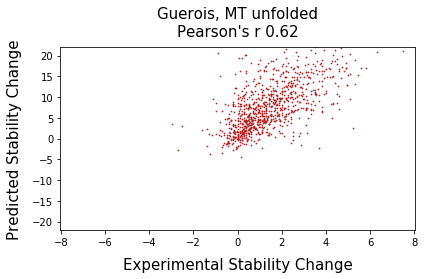

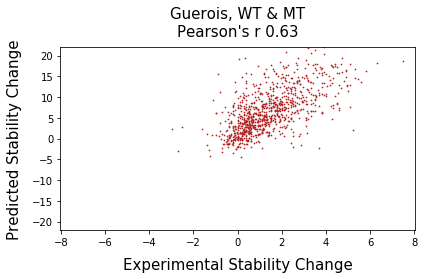

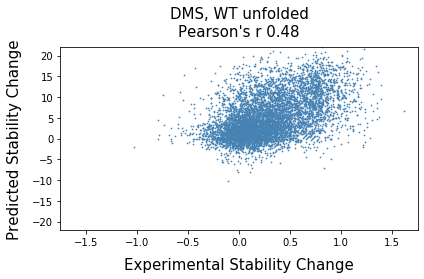

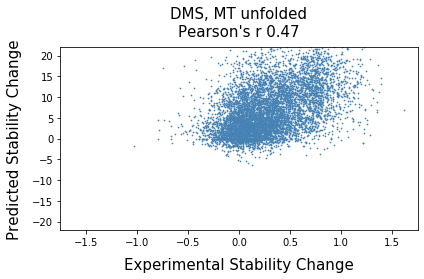

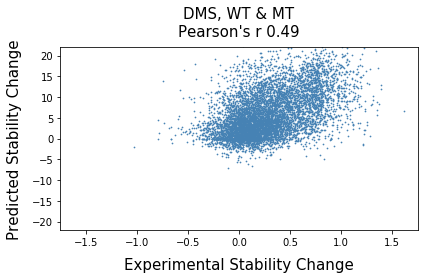

<IPython.core.display.Javascript object>

In [25]:
VANILLA_PHAISTOS_STATISTICS_RS = defaultdict(list)
for i in range(len(cavity_model_infer_nets)):
    for data_set in ["protein_g", "guerois", "dms"]:
        fig, ax, _ = scatter_pred_vs_true(
            ddg_data_dict[data_set]["ddg"],
            ddg_data_dict[data_set][f"ddg_pred_wt_phaistos_no_ds_{i}"],
            color=dataset_color_mapping[data_set],
            title=f"{dataset_name_mapping[data_set]}, WT unfolded",
        )
        fig, ax, _ = scatter_pred_vs_true(
            ddg_data_dict[data_set]["ddg"],
            ddg_data_dict[data_set][f"ddg_pred_mt_phaistos_no_ds_{i}"],
            color=dataset_color_mapping[data_set],
            title=f"{dataset_name_mapping[data_set]}, MT unfolded",
        )

        fig, ax, pearsons_r = scatter_pred_vs_true(
            ddg_data_dict[data_set]["ddg"],
            ddg_data_dict[data_set][f"ddg_pred_wt_and_mt_phaistos_no_ds_{i}"],
            color=dataset_color_mapping[data_set],
            title=f"{dataset_name_mapping[data_set]}, WT & MT",
        )
        VANILLA_PHAISTOS_STATISTICS_RS[data_set].append(pearsons_r)


### Molecular Dynamics

protein_g
guerois
dms
protein_g
guerois
dms
protein_g
guerois
dms
protein_g
guerois
dms
protein_g
guerois
dms
protein_g
guerois
dms


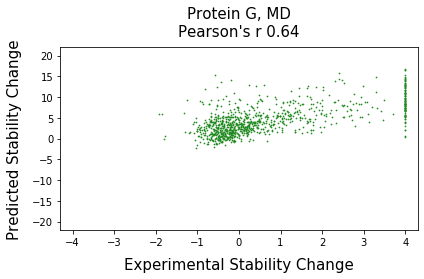

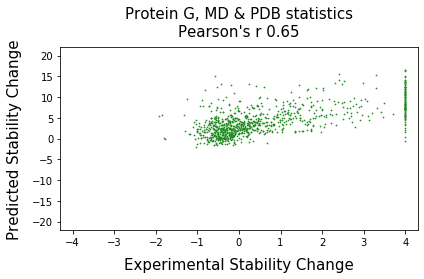

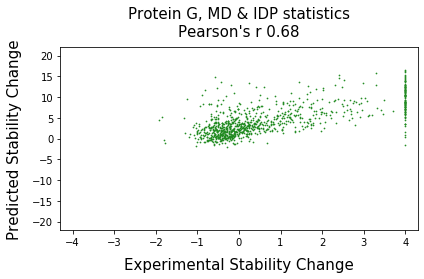

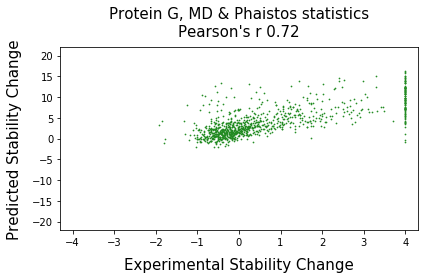

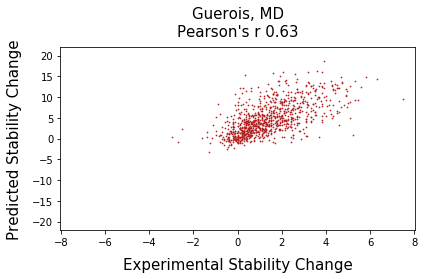

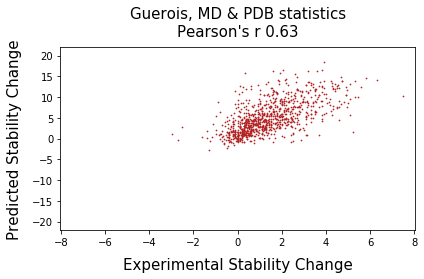

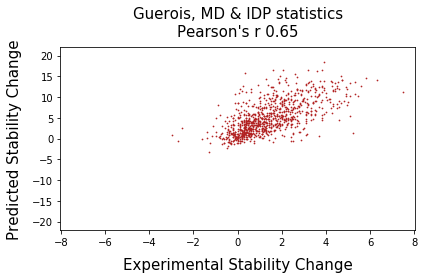

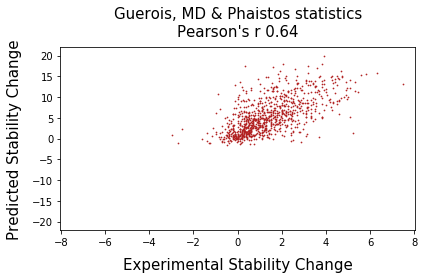

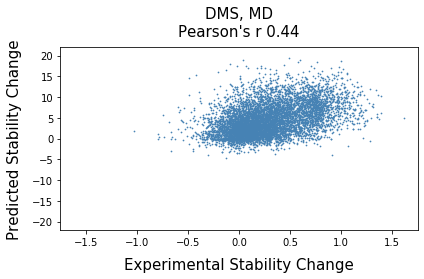

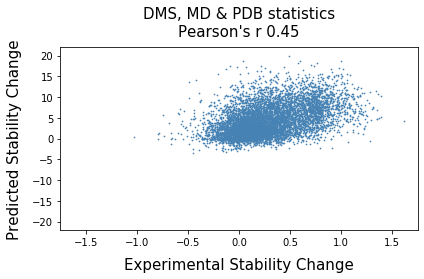

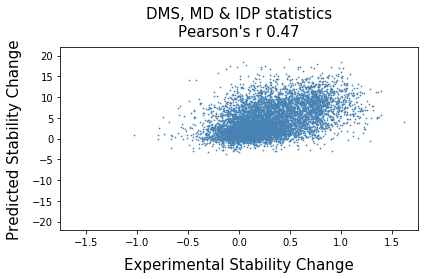

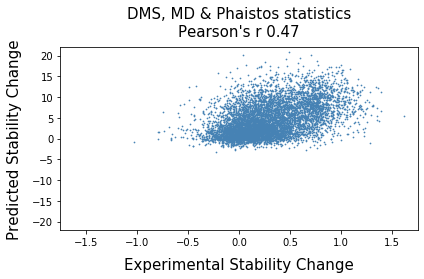

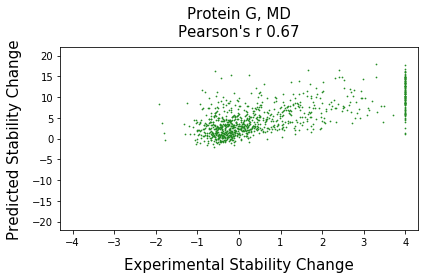

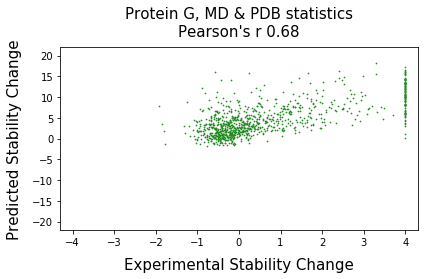

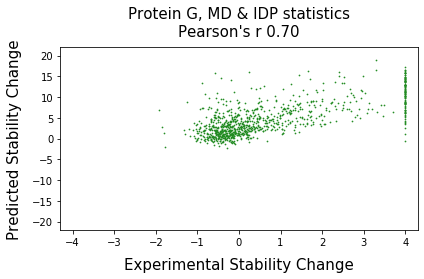

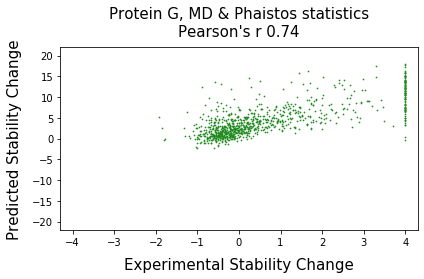

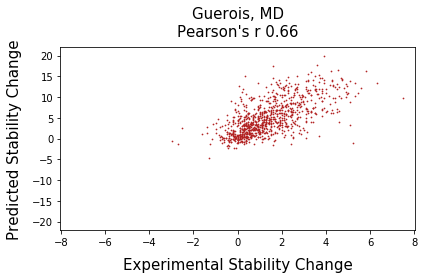

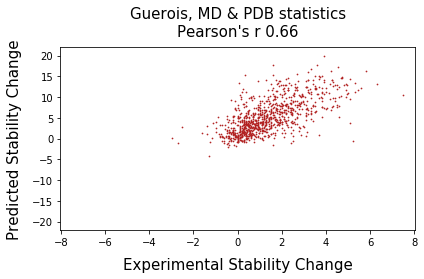

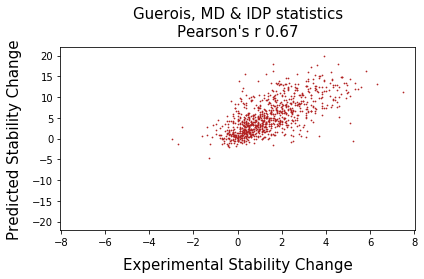

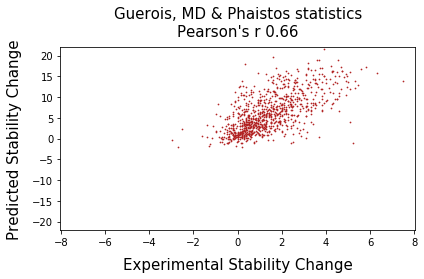

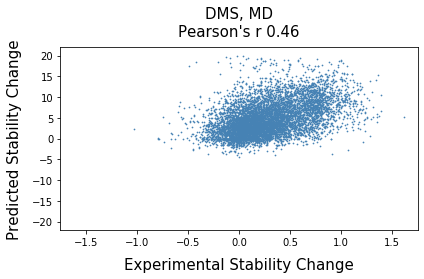

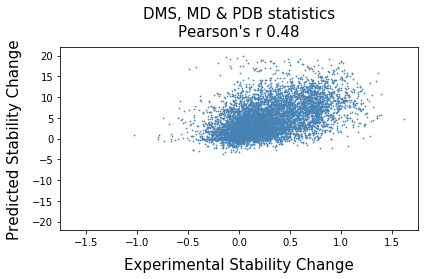

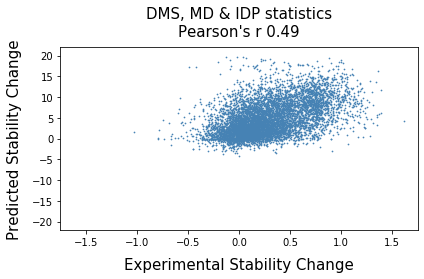

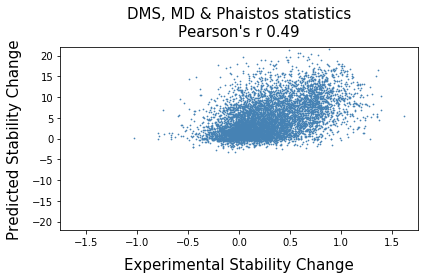

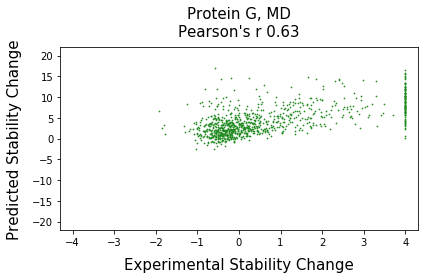

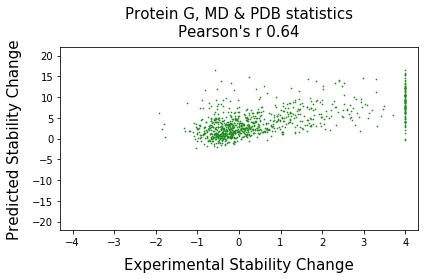

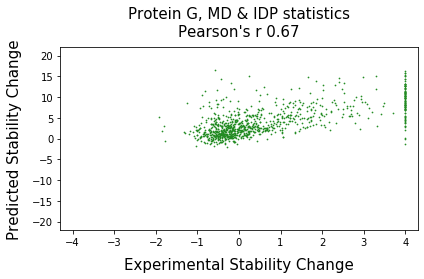

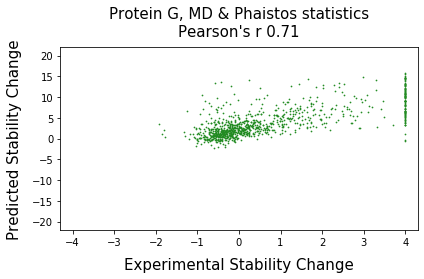

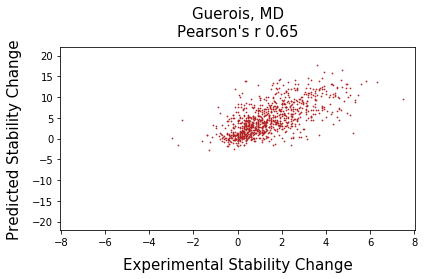

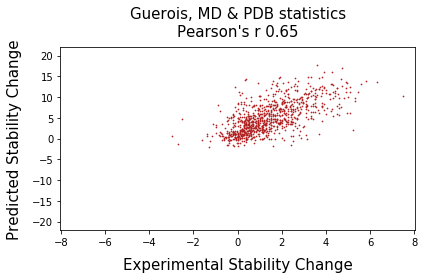

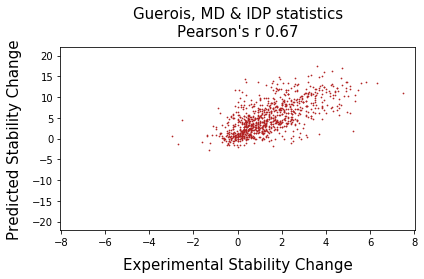

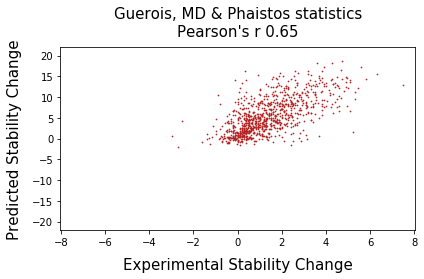

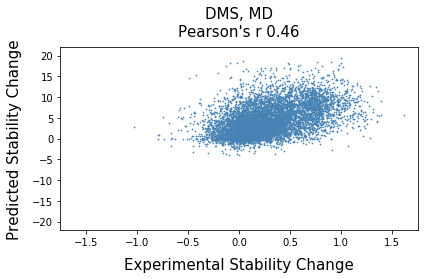

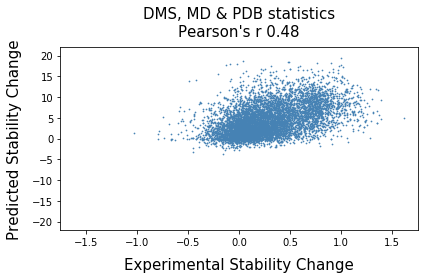

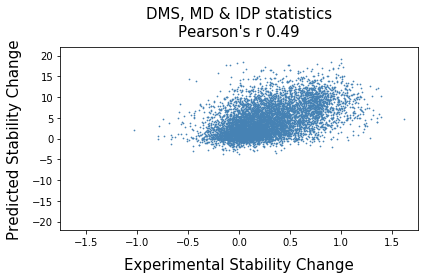

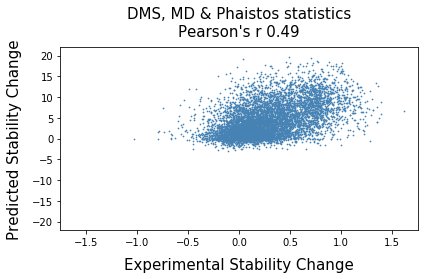

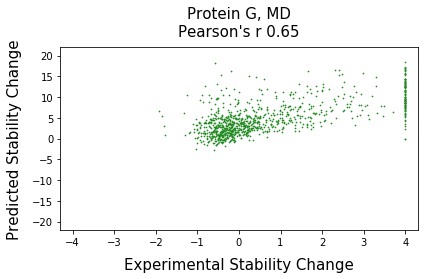

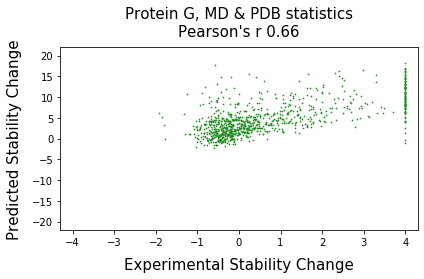

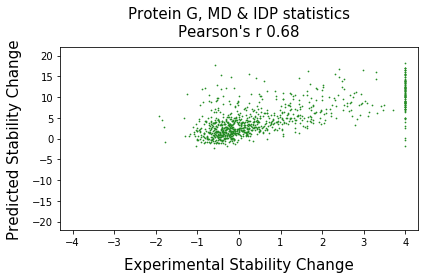

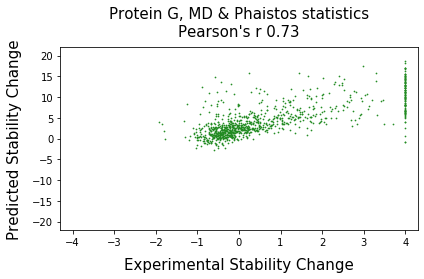

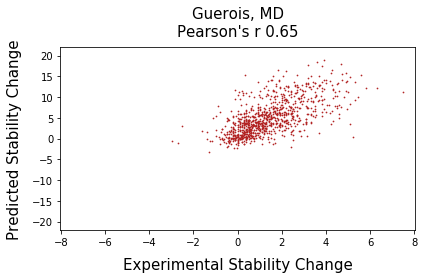

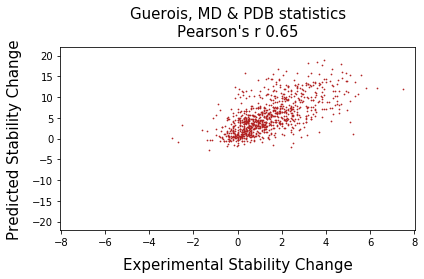

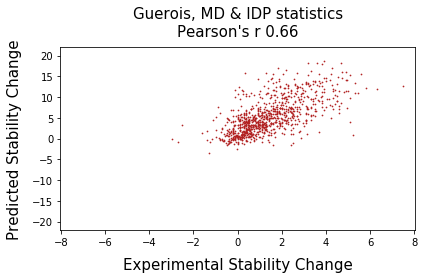

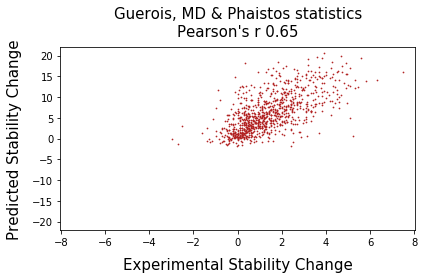

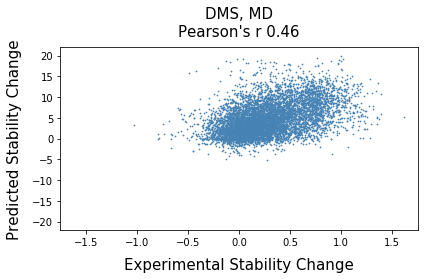

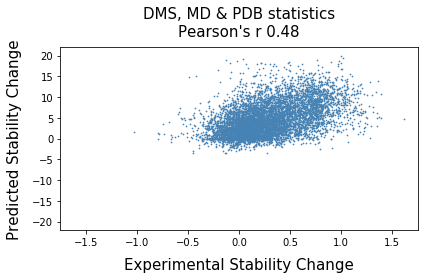

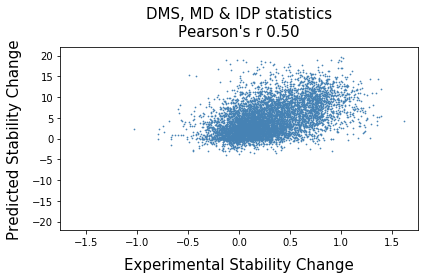

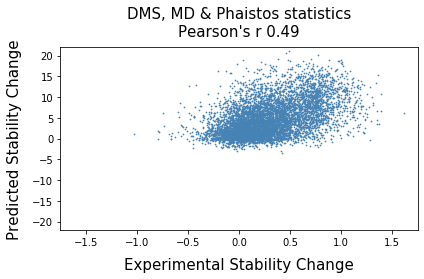

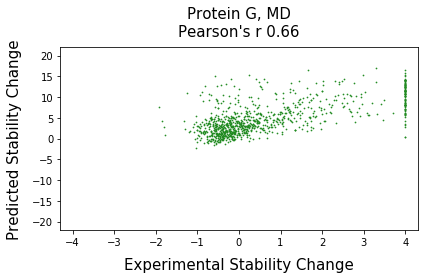

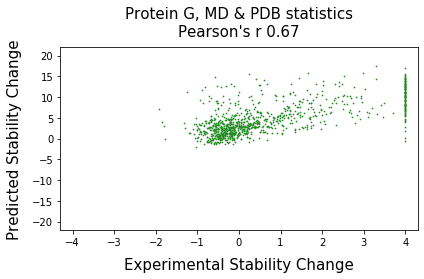

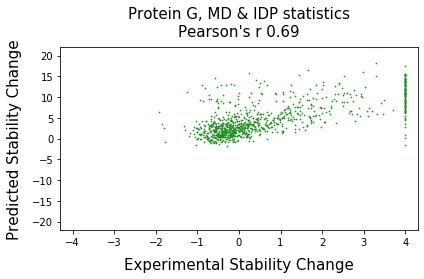

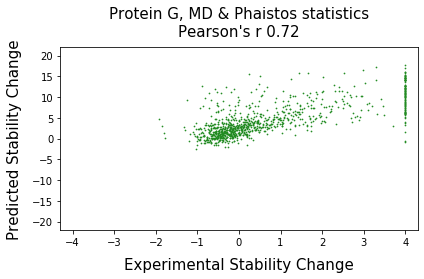

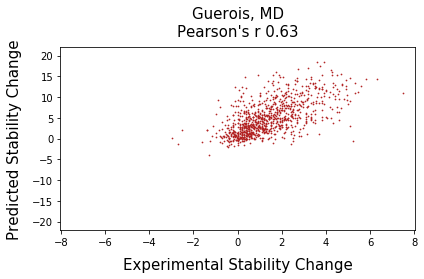

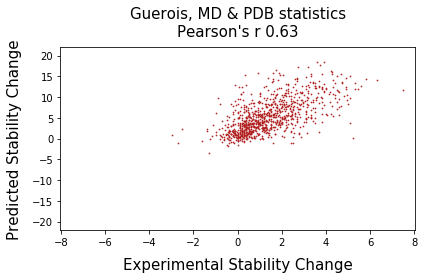

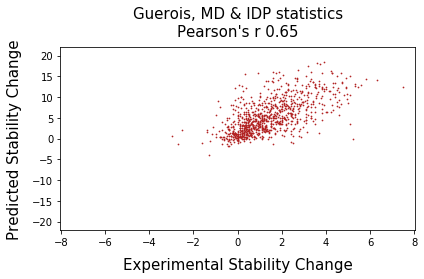

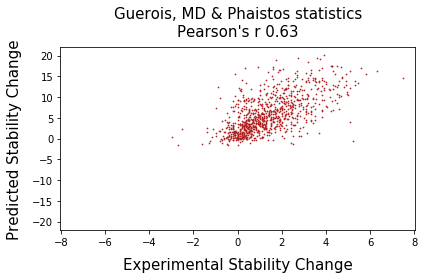

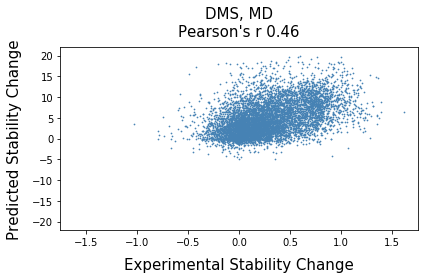

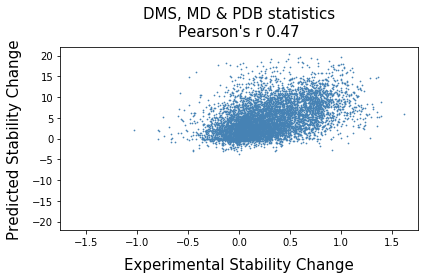

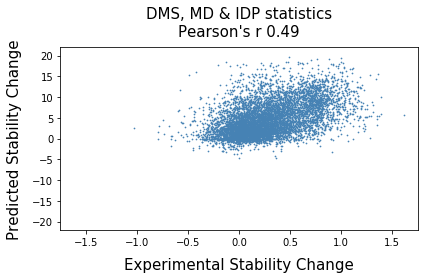

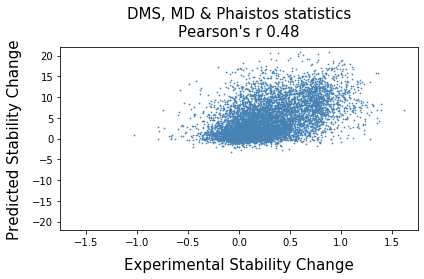

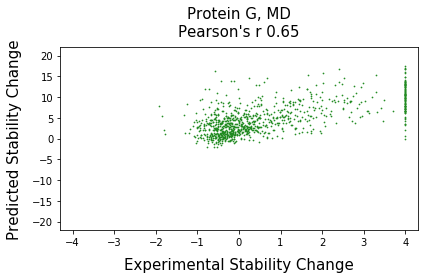

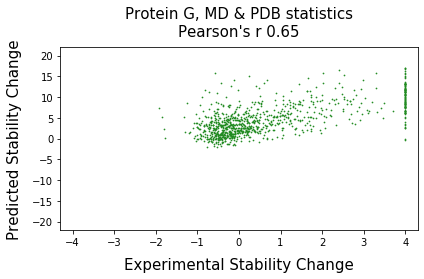

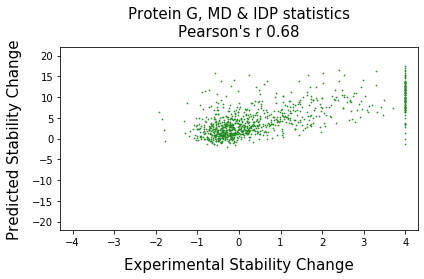

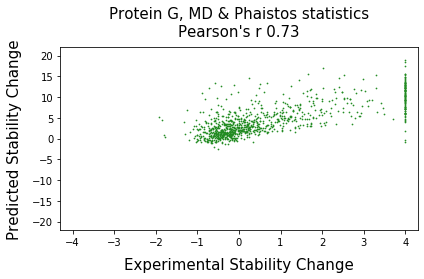

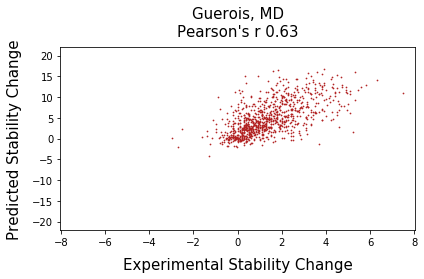

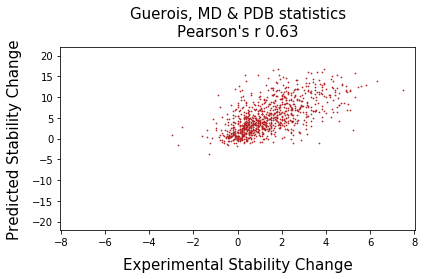

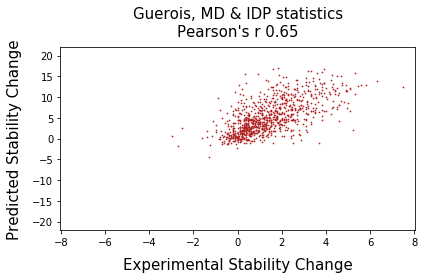

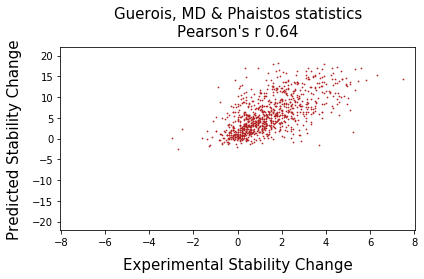

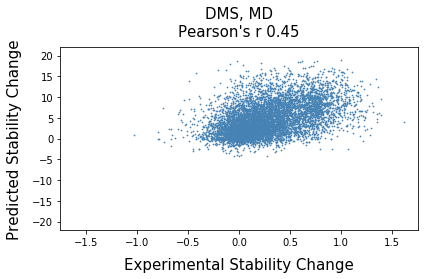

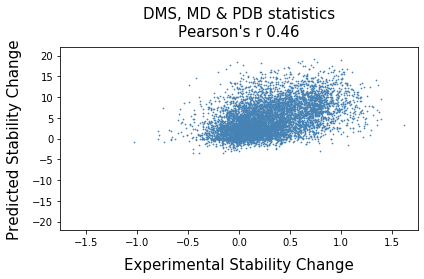

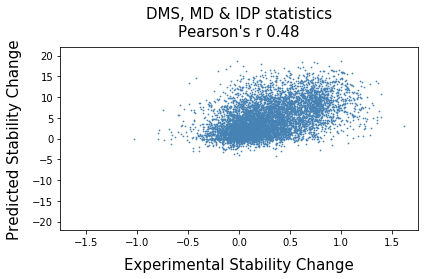

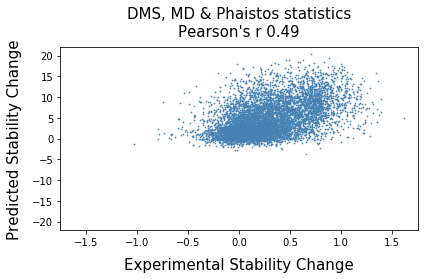

<IPython.core.display.Javascript object>

In [26]:
VANILLA_MD_RS = defaultdict(list)
VANILLA_PDB_STATISTICS_MD_RS = defaultdict(list)
VANILLA_IDP_STATISTICS_MD_RS = defaultdict(list)
VANILLA_PHA_STATISTICS_MD_RS = defaultdict(list)

for i in range(len(cavity_model_infer_nets)):
    for data_set in ["protein_g", "guerois", "dms"]:
        print(data_set)
        fig, ax, pearsons_r = scatter_pred_vs_true(
            ddg_data_dict[data_set]["ddg"],
            ddg_data_dict[data_set][f"ddg_pred_md_no_ds_all_{i}"],
            color=dataset_color_mapping[data_set],
            title=f"{dataset_name_mapping[data_set]}, MD",
        )
        VANILLA_MD_RS[data_set].append(pearsons_r)

        fig, ax, pearsons_r = scatter_pred_vs_true(
            ddg_data_dict[data_set]["ddg"],
            ddg_data_dict[data_set][f"ddg_pred_md_pdb_statistics_no_ds_all_{i}"],
            color=dataset_color_mapping[data_set],
            title=f"{dataset_name_mapping[data_set]}, MD & PDB statistics",
        )
        VANILLA_PDB_STATISTICS_MD_RS[data_set].append(pearsons_r)

        fig, ax, pearsons_r = scatter_pred_vs_true(
            ddg_data_dict[data_set]["ddg"],
            ddg_data_dict[data_set][f"ddg_pred_md_idp_statistics_no_ds_all_{i}"],
            color=dataset_color_mapping[data_set],
            title=f"{dataset_name_mapping[data_set]}, MD & IDP statistics",
        )
        VANILLA_IDP_STATISTICS_MD_RS[data_set].append(pearsons_r)

        fig, ax, pearsons_r = scatter_pred_vs_true(
            ddg_data_dict[data_set]["ddg"],
            ddg_data_dict[data_set][f"ddg_pred_md_phaistos_mt_and_wt_statistics_no_ds_{i}"],
            color=dataset_color_mapping[data_set],
            title=f"{dataset_name_mapping[data_set]}, MD & Phaistos statistics",
        )
        VANILLA_PHA_STATISTICS_MD_RS[data_set].append(pearsons_r)


# PLOTS FOR PAPER

## Figure 2:

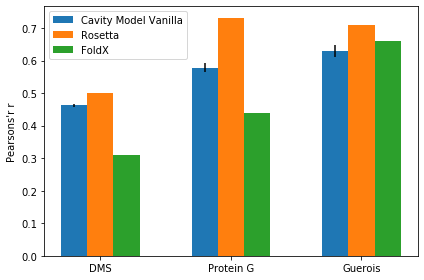

<IPython.core.display.Javascript object>

In [27]:
labels = ["DMS", "Protein G", "Guerois"]

cavity_correlations = [
    np.mean(ULTRA_VANILLA_RS["dms"]),
    np.mean(ULTRA_VANILLA_RS["protein_g"]),
    np.mean(ULTRA_VANILLA_RS["guerois"]),
]

cavity_stds = [
    np.std(ULTRA_VANILLA_RS["dms"]),
    np.std(ULTRA_VANILLA_RS["protein_g"]),
    np.std(ULTRA_VANILLA_RS["guerois"]),
]

rosetta_correlations = [0.5, 0.73, 0.71]
foldx_correlations = [0.31, 0.44, 0.66]

# Dump data for wouter
df_figure_2 = pd.DataFrame(
    {
        "data_set": labels,
        "cavity_correlations": cavity_correlations,
        "cavity_stds": cavity_stds,
        "rosetta_correlations": rosetta_correlations,
        "foldx_correlations": foldx_correlations,
    }
)
df_figure_2.to_csv("wouter_plot_data/fig2.csv", index_label="i")

x = np.arange(len(labels))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(
    x - width,
    cavity_correlations,
    width,
    yerr=cavity_stds,
    label="Cavity Model Vanilla",
)
rects2 = ax.bar(x, rosetta_correlations, width, label="Rosetta")
rects3 = ax.bar(x + width, foldx_correlations, width, label="FoldX")

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel("Pearsons'r r")
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


fig.tight_layout()

plt.show()

## Figure 3:

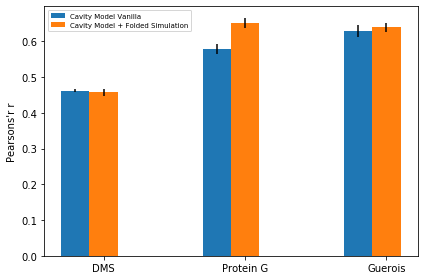

<IPython.core.display.Javascript object>

In [28]:
labels = ["DMS", "Protein G", "Guerois"]

cavity_correlations = [
    np.mean(ULTRA_VANILLA_RS["dms"]),
    np.mean(ULTRA_VANILLA_RS["protein_g"]),
    np.mean(ULTRA_VANILLA_RS["guerois"]),
]
cavity_md_correlations = [
    np.mean(VANILLA_MD_RS["dms"]),
    np.mean(VANILLA_MD_RS["protein_g"]),
    np.mean(VANILLA_MD_RS["guerois"]),
]

cavity_stds = [
    np.std(ULTRA_VANILLA_RS["dms"]),
    np.std(ULTRA_VANILLA_RS["protein_g"]),
    np.std(ULTRA_VANILLA_RS["guerois"]),
]
cavity_md_stds = [
    np.std(VANILLA_MD_RS["dms"]),
    np.std(VANILLA_MD_RS["protein_g"]),
    np.std(VANILLA_MD_RS["guerois"]),
]

# Dump data for wouter
df_figure_3 = pd.DataFrame(
    {
        "data_set": labels,
        "cavity_vanilla": cavity_correlations,
        "cavity_vanilla_stds": cavity_stds,
        "cavity_vanilla_md": cavity_md_correlations,
        "cavity_vanilla_md_stds": cavity_md_stds,
    }
)
df_figure_3.to_csv("wouter_plot_data/fig3.csv", index_label="i")


x = np.arange(len(labels))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(
    x - width,
    cavity_correlations,
    width,
    yerr=cavity_stds,
    label="Cavity Model Vanilla",
)
rects2 = ax.bar(
    x,
    cavity_md_correlations,
    width,
    yerr=cavity_md_stds,
    label="Cavity Model + Folded Simulation",
)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel("Pearsons'r r")
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(fontsize=7)


fig.tight_layout()

plt.show()

## Plot 4:

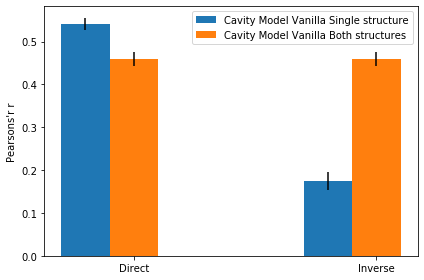

<IPython.core.display.Javascript object>

In [29]:
labels = ["Direct", "Inverse"]

cavity_single_structure_correlations = [
    np.mean(ULTRA_VANILLA_RS["symmetric_direct"]),
    np.mean(ULTRA_VANILLA_RS["symmetric_inverse"]),
]
cavity_both_structure_correlations = [
    np.mean(VANILLA_BOTH_STRUCTURES_RS["symmetric_direct"]),
    np.mean(VANILLA_BOTH_STRUCTURES_RS["symmetric_inverse"]),
]

cavity_single_structure_stds = [
    np.std(ULTRA_VANILLA_RS["symmetric_direct"]),
    np.std(ULTRA_VANILLA_RS["symmetric_inverse"]),
]
cavity_both_structure_stds = [
    np.std(VANILLA_BOTH_STRUCTURES_RS["symmetric_direct"]),
    np.std(VANILLA_BOTH_STRUCTURES_RS["symmetric_inverse"]),
]

# Dump data for wouter
df_figure_4 = pd.DataFrame(
    {
        "direction": labels,
        "cavity_single_structure": cavity_single_structure_correlations,
        "cavity_single_structure_stds": cavity_single_structure_stds,
        "cavity_both_structures": cavity_both_structure_correlations,
        "cavity_both_structures_stds": cavity_both_structure_stds,
    }
)
df_figure_4.to_csv("wouter_plot_data/fig4.csv", index_label="i")


x = np.arange(len(labels))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(
    x - width,
    cavity_single_structure_correlations,
    width,
    yerr=cavity_single_structure_stds,
    label="Cavity Model Vanilla Single structure",
)
rects2 = ax.bar(
    x,
    cavity_both_structure_correlations,
    width,
    yerr=cavity_both_structure_stds,
    label="Cavity Model Vanilla Both structures",
)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel("Pearsons'r r")
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

plt.show()

## Plot 6:

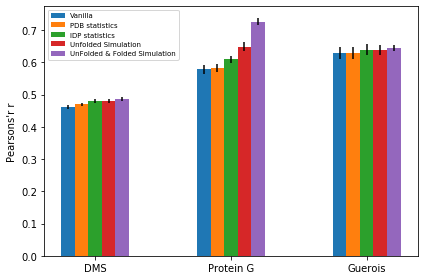

<IPython.core.display.Javascript object>

In [30]:
labels = ["DMS", "Protein G", "Guerois"]

cavity = [
    np.mean(ULTRA_VANILLA_RS["dms"]),
    np.mean(ULTRA_VANILLA_RS["protein_g"]),
    np.mean(ULTRA_VANILLA_RS["guerois"]),
]
cavity_pdb_statistics = [
    np.mean(VANILLA_PDB_STATISTICS_RS["dms"]),
    np.mean(VANILLA_PDB_STATISTICS_RS["protein_g"]),
    np.mean(VANILLA_PDB_STATISTICS_RS["guerois"]),
]
cavity_idp_statistics = [
    np.mean(VANILLA_IDP_STATISTICS_RS["dms"]),
    np.mean(VANILLA_IDP_STATISTICS_RS["protein_g"]),
    np.mean(VANILLA_IDP_STATISTICS_RS["guerois"]),
]
cavity_phaistos_statistics = [
    np.mean(VANILLA_PHAISTOS_STATISTICS_RS["dms"]),
    np.mean(VANILLA_PHAISTOS_STATISTICS_RS["protein_g"]),
    np.mean(VANILLA_PHAISTOS_STATISTICS_RS["guerois"]),
]
cavity_phaistos_statistics_md = [
    np.mean(VANILLA_PHA_STATISTICS_MD_RS["dms"]),
    np.mean(VANILLA_PHA_STATISTICS_MD_RS["protein_g"]),
    np.mean(VANILLA_PHA_STATISTICS_MD_RS["guerois"]),
]

cavity_stds = [
    np.std(ULTRA_VANILLA_RS["dms"]),
    np.std(ULTRA_VANILLA_RS["protein_g"]),
    np.std(ULTRA_VANILLA_RS["guerois"]),
]
cavity_pdb_statistics_stds = [
    np.std(VANILLA_PDB_STATISTICS_RS["dms"]),
    np.std(VANILLA_PDB_STATISTICS_RS["protein_g"]),
    np.std(VANILLA_PDB_STATISTICS_RS["guerois"]),
]
cavity_idp_statistics_stds = [
    np.std(VANILLA_IDP_STATISTICS_RS["dms"]),
    np.std(VANILLA_IDP_STATISTICS_RS["protein_g"]),
    np.std(VANILLA_IDP_STATISTICS_RS["guerois"]),
]
cavity_phaistos_statistics_stds = [
    np.std(VANILLA_PHAISTOS_STATISTICS_RS["dms"]),
    np.std(VANILLA_PHAISTOS_STATISTICS_RS["protein_g"]),
    np.std(VANILLA_PHAISTOS_STATISTICS_RS["guerois"]),
]
cavity_phaistos_statistics_md_stds = [
    np.std(VANILLA_PHA_STATISTICS_MD_RS["dms"]),
    np.std(VANILLA_PHA_STATISTICS_MD_RS["protein_g"]),
    np.std(VANILLA_PHA_STATISTICS_MD_RS["guerois"]),
]

# Dump data for wouter
df_figure_6 = pd.DataFrame(
    {
        "data_set": labels,
        "cavity": cavity,
        "cavity_pdb_statistics": cavity_pdb_statistics,
        "cavity_idp_statistics": cavity_idp_statistics,
        "cavity_phaistos_statistics": cavity_phaistos_statistics,
        "cavity_phaistos_statistics_md": cavity_phaistos_statistics_md,
        "cavity_stds": cavity_stds,
        "cavity_pdb_statistics_stds": cavity_pdb_statistics_stds,
        "cavity_idp_statistics_stds": cavity_idp_statistics_stds,
        "cavity_phaistos_statistics_stds": cavity_phaistos_statistics_stds,
        "cavity_phaistos_statistics_md_stds": cavity_phaistos_statistics_md_stds,
    }
)
df_figure_6.to_csv("wouter_plot_data/fig6.csv", index_label="i")


x = np.arange(len(labels)) * 2  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots()
rects0 = ax.bar(x - 2 * width, cavity, width, yerr=cavity_stds, label="Vanilla")
rects1 = ax.bar(
    x - width,
    cavity_pdb_statistics,
    width,
    yerr=cavity_pdb_statistics_stds,
    label="PDB statistics",
)
rects2 = ax.bar(
    x,
    cavity_idp_statistics,
    width,
    yerr=cavity_idp_statistics_stds,
    label="IDP statistics",
)
rects3 = ax.bar(
    x + width,
    cavity_phaistos_statistics,
    width,
    yerr=cavity_phaistos_statistics_stds,
    label="Unfolded Simulation",
)
rects4 = ax.bar(
    x + 2 * width,
    cavity_phaistos_statistics_md,
    width,
    yerr=cavity_phaistos_statistics_md_stds,
    label="UnFolded & Folded Simulation",
)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel("Pearsons'r r")
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(fontsize=7)


fig.tight_layout()

plt.show()

# Downstream model

### Performance without augmentation Vanilla

Define training dataloader and eval dataloaders

In [31]:
from cavity_model import DDGToTensor, DDGToTensorPhaistosAndMD

<IPython.core.display.Javascript object>

In [32]:
ddg_dataloaders_train_dict = helpers.get_ddg_training_dataloaders(
    ddg_data_dict, BATCH_SIZE_DDG, SHUFFLE_DDG, DDGToTensor
)
ddg_dataloaders_val_dict = helpers.get_ddg_validation_dataloaders(
    ddg_data_dict, DDGToTensor
)

<IPython.core.display.Javascript object>

In [33]:
ddg_data_dict["protein_g"]

pdbid chainid variant     ddg  \
0    1PGA       A     M1A -0.1407   
1    1PGA       A     M1D -0.3795   
2    1PGA       A     M1E -0.6414   
3    1PGA       A     M1L -0.4573   
4    1PGA       A     T2E -0.1299   
..    ...     ...     ...     ...   
902  1PGA       A     M1Q -0.4025   
903  1PGA       A     M1R -0.5102   
904  1PGA       A     M1S -0.6800   
905  1PGA       A     M1T -0.4983   
906  1PGA       A     M1Y -0.6800   

                                                resenv  wt_idx  mt_idx  \
0    <ResidueEnvironment with 130 atoms. pdb_id: 1P...      10       0   
1    <ResidueEnvironment with 130 atoms. pdb_id: 1P...      10       2   
2    <ResidueEnvironment with 130 atoms. pdb_id: 1P...      10       3   
3    <ResidueEnvironment with 130 atoms. pdb_id: 1P...      10       9   
4    <ResidueEnvironment with 157 atoms. pdb_id: 1P...      16       3   
..                                                 ...     ...     ...   
902  <ResidueEnvironment with 130 atoms. pdb_id: 1P...      10      13   
903  <ResidueEnvironment with 130 atoms. pdb_id: 1P...      10      14   
904  <ResidueEnvironment with 130 atoms. pdb_id: 1P...      10      15   
905  <ResidueEnvironment with 130 atoms. pdb_id: 1P...      10      16   
906  <ResidueEnvironment with 130 atoms. pdb_id: 1P...      10      19   

                                                nlls_0  wt_nll_0  mt_nll_0  \
0    [3.3562713, 3.9009457, 4.588267, 2.5037181, 6....  1.401340  3.356271   
1    [3.3562713, 3.9009457, 4.588267, 2.5037181, 6....  1.401340  4.588267   
2    [3.3562713, 3.9009457, 4.588267, 2.5037181, 6....  1.401340  2.503718   
3    [3.3562713, 3.9009457, 4.588267, 2.5037181, 6....  1.401340  4.369485   
4    [6.8084702, 8.124421, 5.84448, 2.760767, 6.774...  0.773342  2.760767   
..                                                 ...       ...       ...   
902  [3.401909, 3.9082263, 4.657872, 2.5947013, 6.4...  1.358469  2.846078   
903  [3.401909, 3.9082263, 4.657872, 2.5947013, 6.4...  1.358469  4.379262   
904  [3.401909, 3.9082263, 4.657872, 2.5947013, 6.4...  1.358469  4.249102   
905  [3.401909, 3.9082263, 4.657872, 2.5947013, 6.4...  1.358469  0.872728   
906  [3.401909, 3.9082263, 4.657872, 2.5947013, 6.4...  1.358469  6.107160   

     wt_nlf_0  mt_nlf_0  ddg_pred_ultra_vanilla_0  ddg_pred_no_ds_0  \
0    3.785957  2.483982                  1.954931          3.256906   
1    3.785957  2.824680                  3.186927          4.148204   
2    3.785957  2.712832                  1.102378          2.175503   
3    3.785957  2.433114                  2.968145          4.320988   
4    2.896883  2.712832                  1.987425          2.171476   
..        ...       ...                       ...               ...   
902  3.785957  3.338515                  1.487608          1.935050   
903  3.785957  3.035567                  3.020793          3.771183   
904  3.785957  2.844502                  2.890632          3.832087   
905  3.785957  2.896883                 -0.485741          0.403333   
906  3.785957  3.311580                  4.748691          5.223068   

     wt_idp_nlf_0  mt_idp_nlf_0  ddg_pred_idp_no_ds_0  \
0        3.974215      2.679916              3.249230   
1        3.974215      2.836449              4.324693   
2        3.974215      2.405165              2.671428   
3        3.974215      2.544290              4.398070   
4        2.861809      2.405165              2.444070   
..            ...           ...                   ...   
902      3.974215      3.039859              2.421964   
903      3.974215      2.705216              4.289792   
904      3.974215      2.533442              4.331405   
905      3.974215      2.861809              0.626664   
906      3.974215      4.207830              4.515076   

                                                nlls_1  wt_nll_1  mt_nll_1  \
0    [3.269724, 5.208636, 2.8909955, 2.3118136, 4.3...  1.006030  3.269724   
1    [3.269724, 5.208636, 2.8909955, 2.

<IPython.core.display.Javascript object>

### Train and report on the data that is not used during training -->

In [34]:
pearsons_r_results_dict = helpers.train_downstream_and_evaluate(
    ddg_dataloaders_train_dict,
    ddg_dataloaders_val_dict,
    DEVICE,
    LEARNING_RATE_DDG,
    EPOCHS_DDG,
)

KeyError: 'wt_nll'

<IPython.core.display.Javascript object>

In [ ]:
for data_set in pearsons_r_results_dict.keys():
    _ = plot_validation_performance(
        f"Trained on {dataset_name_mapping[data_set]}",
        pearsons_r_results_dict[data_set],
    )

### Performance without augmentation With Phaistos and MD

In [ ]:
ddg_dataloaders_train_dict = helpers.get_ddg_training_dataloaders(
    ddg_data_dict, BATCH_SIZE_DDG, SHUFFLE_DDG, DDGToTensorPhaistosAndMD
)
ddg_dataloaders_val_dict = helpers.get_ddg_validation_dataloaders(
    ddg_data_dict, DDGToTensorPhaistosAndMD
)

In [ ]:
pearsons_r_results_dict = helpers.train_downstream_and_evaluate(
    ddg_dataloaders_train_dict,
    ddg_dataloaders_val_dict,
    DEVICE,
    LEARNING_RATE_DDG,
    EPOCHS_DDG,
)

In [ ]:
for data_set in pearsons_r_results_dict.keys():
    _ = plot_validation_performance(
        f"Trained on {dataset_name_mapping[data_set]}",
        pearsons_r_results_dict[data_set],
    )

### Performance with augmentation Vanilla

Before training we "augment" our dataset simply by adding the reverse mutation with -ddG value

In [ ]:
ddg_data_dict_augmented = helpers.augment_with_reverse_mutation(ddg_data_dict)

Define training dataloader (augmented data) and eval dataloaders (original data)

In [ ]:
ddg_dataloaders_train_dict = helpers.get_ddg_training_dataloaders(
    ddg_data_dict_augmented, BATCH_SIZE_DDG, SHUFFLE_DDG, DDGToTensor
)
ddg_dataloaders_val_dict = helpers.get_ddg_validation_dataloaders(
    ddg_data_dict, DDGToTensor
)

Train and report on the data that is not used during training

In [ ]:
pearsons_r_results_dict = helpers.train_downstream_and_evaluate(
    ddg_dataloaders_train_dict,
    ddg_dataloaders_val_dict,
    DEVICE,
    LEARNING_RATE_DDG,
    EPOCHS_DDG,
)

In [ ]:
for data_set in pearsons_r_results_dict.keys():
    _ = plot_validation_performance(
        f"Trained on {dataset_name_mapping[data_set]}",
        pearsons_r_results_dict[data_set],
    )

### Performance with augmentation With Phaistos and MD

In [ ]:
ddg_dataloaders_train_dict = helpers.get_ddg_training_dataloaders(
    ddg_data_dict_augmented, BATCH_SIZE_DDG, SHUFFLE_DDG, DDGToTensorPhaistosAndMD
)
ddg_dataloaders_val_dict = helpers.get_ddg_validation_dataloaders(
    ddg_data_dict, DDGToTensorPhaistosAndMD
)

In [ ]:
pearsons_r_results_dict = helpers.train_downstream_and_evaluate(
    ddg_dataloaders_train_dict,
    ddg_dataloaders_val_dict,
    DEVICE,
    LEARNING_RATE_DDG,
    EPOCHS_DDG,
)

In [ ]:
with open("pearsons_r_results_dict.pickle", "wb") as handle:
    pickle.dump(pearsons_r_results_dict, handle, protocol=pickle.HIGHEST_PROTOCOL

In [ ]:
for data_set in pearsons_r_results_dict.keys():
    _ = plot_validation_performance(
        f"Trained on {dataset_name_mapping[data_set]}",
        pearsons_r_results_dict[data_set],
    )